# Norwegian Airbnb Insights
This notebook is part of the delivery for a project in the Udacity Data Science Nanodegree. It contains data wrangling and analysis/visualization for an attempt to answer the following questions:

* Which areas of Oslo have the most Airbnb listings?
* Which characteristics drives the Airbnb listing prices of Oslo apartments?
* Is there a relationship between official housing prices and the prices people are asking for on Airbnb?
* Is it possible to use machine learning techniques to predict the price of a listing?


In [1]:
# All neccessary imports are placed here
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import folium
from folium import plugins
import json
import os
import requests
from math import ceil, sqrt
from bs4 import BeautifulSoup
from collections import Counter
from scipy import stats


from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn import linear_model
from sklearn import svm

# Plot inline with high resolution.
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Setting some pandas options for better visual assesment.
#pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_columns', None)

C:\miniconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


# Gather data
The first section of this notebook contans code to gather the raw data needed for my analysis.

**For future work - not used for submission**
```python
# Get demographics data - this was downloaded manually and converted to xlsx for simplicty.
# Downloaded from:
# https://www.oslo.kommune.no/getfile.php/13201688/Innhold/Politikk%20og%20administrasjon/
# Statistikk/Faktaark%20bydelene%202017/Tabellvedlegg.ods
oslo_data_dict = {}
for i in range(1,7,1):
    if i == 1:
        header = 2
    else:
        header = 1
    df = pd.read_excel('./data/Oslodata/Tabellvedlegg.xlsx', sheet_name='Tabell_{}'.format(i), header=header)
    df = df[df.index.str.startswith('Bydel')]
    df['Bydel'] = df.index.str.replace('Bydel', '').str.strip(' ')
    df = df.reset_index()
    df = df.drop('index', axis=1)
    oslo_data_dict['Tabell_{}'.format(i)] = df
```

**For future work - not used for submission**
```python
# Create dataframes on Oslo demographics data
oslo_data_dict['Tabell_2'].head(20)
population = oslo_data_dict['Tabell_1']
age_distribution = oslo_data_dict['Tabell_2']
immigration = oslo_data_dict['Tabell_3']
living_conditions = oslo_data_dict['Tabell_4']
living_env_indicators = oslo_data_dict['Tabell_6']
```

In [2]:
# Data downloaded from Airbnb - data for Oslo, Norway in August 2018
# Thanks to Airbnb for providing the data
# Downloaded from http://insideairbnb.com/get-the-data.html

listings = pd.read_csv('./data/Oslodata/aug_listings.csv/listings.csv')
listings_agg = pd.read_csv('./data/Oslodata/aug_listings_agg.csv')
reviews = pd.read_csv('./data/Oslodata/aug_reviews.csv/reviews.csv')

# Create a raw copy of the listings file, to be able to go back and check columns I might choose to drop from the 
#original frame
listings_copy = listings.copy()

In [3]:
def get_html(url):
    """
    Attempts to get the content at `url`, throws and exception if it fails.
    Returns the content of the response object.
    """
    try:
        resp = requests.get(url, stream=True)
        
    except Exception as e:
        print('Error during requests to {0} : {1}'.format(url, str(e)))
        return None
    
    return resp.content

**Get the HTML file and store it to disk - let's be nice to the provider of this statistics and only run this once.Will make this cell a markdown cell, so that it is not executed.**

```python
# The data scraped is Oslo housing price statistics, given in price per square meter, given by Eiendom Norge 
# (interest group for real estate agents in Norway). However, the link is to a specific real estate agent that provides 
# prices on their home page. Thanks to Krogsveen for supplying this.

html = get_html('https://krogsveen.no/Boligprisstatistikk/Boligprisstatistikk-for-Oslo/(county)/Oslo/(child_area)/Bjerke')

with open('price_stats_raw.html', 'wb') as f:
    f.write(html)
```

In [4]:
def html_to_df(raw_html_file):
    """
    This function takes a specific html file as input and converts it to a dataframe.
    The purpose of the function is to avoid littering the workspace with many global variables that are just temporary
    """
    
    # Read the file from disk
    with open(raw_html_file, 'rb') as f:
        raw_html = f.read()
    
    # Convert to beautifulsoup object
    html = BeautifulSoup(raw_html, 'html.parser')
    
    # Find the json-structure containing all price statistics for Oslo
    lines = str(html.findAll('script')[3].contents[0])
    prices = json.loads(lines.split('\n')[1].split('=')[1].strip(' ;'))

    # Create a dictinoary of neighbourhoods and the last available prices (August 2018 as of writing)
    price_dict = {}
    for neigbourhood in prices.get('related_areas').get('statistics')[0].get('areas'):
        price_dict[neigbourhood.get('name')] = neigbourhood.get('square_meter_prices')[-1]
    
    # Create a dataframe from the price dictionary
    neighbourhood_price_df = pd.Series(price_dict)
    neighbourhood_price_df = pd.DataFrame({'neighbourhood':neighbourhood_price_df.index, 
                                           'avg_price_per_m2':neighbourhood_price_df.values})
    
    # Fix some typing so that it is equal to the Airbnb spelling.
    neighbourhood_price_df.iloc[2, 0] = 'Grünerløkka'
    neighbourhood_price_df.iloc[4, 0] = 'St. Hanshaugen'

    # There are no price statistics for the boroughs Sentrum and Marka - they are not administrative boroughs in oslo
    # and people living there gets their services from close by boroughs - use these to estimate prices for Sentrum and Marka.
    
    # Price in Sentrum
    price_center = neighbourhood_price_df[neighbourhood_price_df.\
                                          neighbourhood.isin(['Frogner','St. Hanshaugen', 'Sagene', 
                                                              'Gamle Oslo', 'Grünerløkka'])]['avg_price_per_m2'].mean()
    
    # Price in Marka
    price_marka = neighbourhood_price_df[neighbourhood_price_df.\
                                         neighbourhood.isin(['Vestre Aker','Nordre Aker', 'Grorud', 'Alna', 
                                                             'Østensjø', 'Søndre Nordstrand'])]['avg_price_per_m2'].mean()
    
    # Add the prices to dataframe
    add_missing = {'Sentrum' : price_center, 'Marka' : price_marka}
    add_missing_df =  pd.DataFrame(pd.Series(add_missing)).reset_index()
    add_missing_df.columns = ['neighbourhood', 'avg_price_per_m2']
    neighbourhood_price_df = pd.concat([neighbourhood_price_df, add_missing_df], axis=0, ignore_index=True)
    
    # Add a rank-column to the prices - will be used to see if increase in price has a correlation with increase
    # in Airbnb listing price
    neighbourhood_price_df['price_rank'] = neighbourhood_price_df['avg_price_per_m2'].rank(method='max', ascending=False)
    
    return neighbourhood_price_df


In [5]:
# The Airbnb .geojson file is encoded with UTF-8 BOM which is not handled well by the map plotting library I will use.
# Re-encoding to utf-8 without BOM.

with open('./data/neighbourhoods.geojson', encoding='utf-8-sig') as json_data:
    oslo_geo_json = json.load(json_data)
    
with open('./data/neighbourhoods_utf.geojson', 'w') as f:
    json.dump(oslo_geo_json, f)

In [6]:
# How many rows are there in the datasets?
print(listings.shape[0])
print(listings_agg.shape[0])
print(reviews.shape[0])

7982
7982
115335


# Data assesment and cleaning
Below is the major part of the data wrangling process - assessing and cleaning data for analysis. My preference is to do the cleaning as I go, to avoid a lot of duplicate/unneccessary work.

In [7]:
# The listings agg and listings contains the same information - which columns are in both, which are only in one or the other?
print('In both datasets:\n-------------------------')
print(*set(listings_agg).intersection(set(listings)), sep='\n')
print('-------------------------\nOnly in small dataset:\n-------------------------')
print(*set(listings_agg).difference(set(listings)), sep='\n')
print('-------------------------\nOnly in large dataset:\n-------------------------')
print(*set(listings).difference(set(listings_agg)), sep='\n')

In both datasets:
-------------------------
host_id
neighbourhood
number_of_reviews
reviews_per_month
last_review
availability_365
host_name
price
longitude
id
latitude
name
room_type
calculated_host_listings_count
minimum_nights
-------------------------
Only in small dataset:
-------------------------
neighbourhood_group
-------------------------
Only in large dataset:
-------------------------
city
review_scores_cleanliness
amenities
scrape_id
access
availability_60
host_identity_verified
is_location_exact
street
review_scores_accuracy
neighbourhood_cleansed
host_listings_count
bathrooms
host_picture_url
listing_url
last_scraped
picture_url
calendar_last_scraped
require_guest_phone_verification
neighborhood_overview
host_since
state
maximum_nights
availability_30
calendar_updated
bed_type
host_verifications
review_scores_checkin
host_url
is_business_travel_ready
space
thumbnail_url
interaction
country_code
notes
weekly_price
market
monthly_price
beds
host_thumbnail_url
license
host_

In [8]:
# View values in listings.
listings.head(1)

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,access,interaction,house_rules,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,market,smart_location,country_code,country,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,42932,https://www.airbnb.com/rooms/42932,20180824213940,2018-08-24,"Charming apartment, Oslo Center, Ro",NaN,"Charming apartment, Oslo Center, Royal House T...","Charming apartment, Oslo Center, Royal House T...",none,(URL HIDDEN),NaN,NaN,The whole flat,I will be on phone or mail 24/7 during you sta...,Comment sense :),NaN,NaN,https://a0.muscache.com/im/pictures/8cbe8e13-4...,NaN,187463,https://www.airbnb.com/users/show/187463,Cecilie,2010-08-01,"Oslo, Oslo, Norway","Fashion clothing designer,Concept developer 47...",within an hour,100%,NaN,t,https://a0.muscache.com/im/users/187463/profil...,https://a0.muscache.com/im/users/187463/profil...,NaN,1,1,"['email', 'phone', 'reviews']",t,f,"Oslo, Oslo, Norway",Frogner,Frogner,NaN,Oslo,Oslo,0253,Oslo,"Oslo, Norway",NO,Norway,59.912336,10.723842,f,Apartment,Entire home/apt,3,1.0,2.0,3.0,Real Bed,"{TV,""Cable TV"",Internet,Wifi,Kitchen,""Free str...",NaN,"$1,924.00","$10,000.00","$25,000.00",NaN,NaN,3,$0.00,2,300,6 months ago,t,3,33,63,338,2018-08-24,31,2013-09-02,2018-07-02,96.0,10.0,10.0,10.0,10.0,10.0,10.0,f,NaN,NaN,t,f,moderate,f,f,1,0.51


In [9]:
# VIew values in smaller file.
listings_agg.head(1)

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,42932,"Charming apartment, Oslo Center, Ro",187463,Cecilie,NaN,Frogner,59.912336,10.723842,Entire home/apt,1924,2,31,2018-07-02,0.51,1,338


**Coment:** From the looks of it, there is no columns from the smaller file that we actually need. It seems however, that the "price" column has been cleaned, so let's merge the files and keep the price only from the smaller file

In [10]:
# Join the smaller file to the larger
listings = listings.merge(listings_agg[['id', 'neighbourhood', 'price']], left_on='id', right_on='id', how='inner')

# Drop and rename redundant columns
listings.drop(['price_x'], axis=1, inplace=True)
listings.drop(['neighbourhood_x'], axis=1, inplace=True)
listings.rename(columns={'price_y': 'price'}, inplace=True)

In [11]:
# Are the neighbourhood_cleansed and neighbourhood_y the same?
(listings.neighbourhood_cleansed == listings.neighbourhood_y).sum()

7982

In [12]:
# Remove neighbourhood_cleansed and rename neighbourhood_y
listings.drop(['neighbourhood_cleansed'], axis=1, inplace=True)
listings.rename(columns={'neighbourhood_y': 'neighbourhood'}, inplace=True)

In [13]:
# The rating columns have many nulls, but still contains some information I want to keep.
# Create a "summary" column keeping a 1 value if the listing has a score above 90.
listings['has_excellent_overall_rating'] = (listings.review_scores_rating >= 90.0).astype(np.int8)

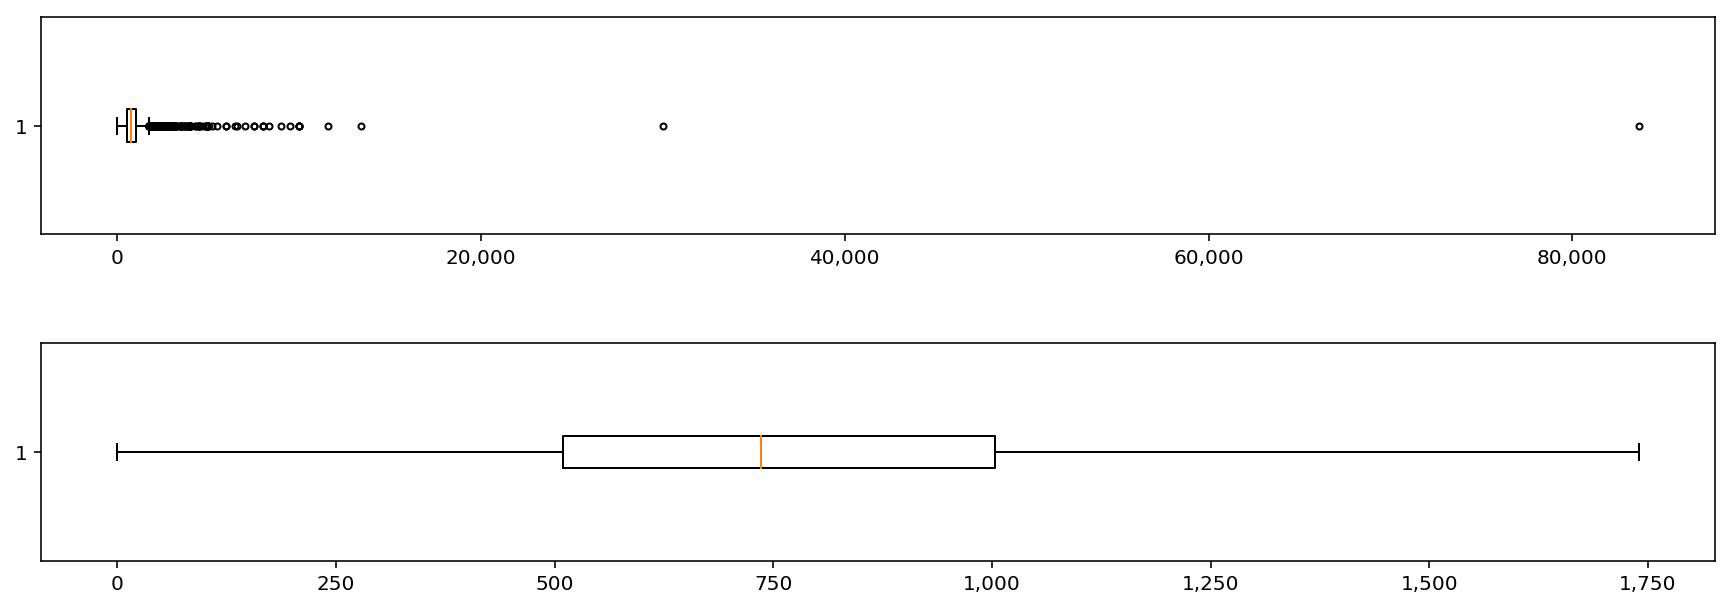

In [14]:
# Have a look at how the price is distributed - box plot of price column (with and without outliers.)
fig, ax = plt.subplots(2,1, figsize=(15,5))
plt.subplots_adjust(hspace = 0.5)
#plt.subplots_adjust(wspace = 0.5)
bp1 = ax[0].boxplot(listings['price'], 0, '.', 0)
bp2 = ax[1].boxplot(listings['price'], 0, '',0)
vals = ax[0].get_xticks()
ax[0].set_xticklabels([format(label, ',.0f') for label in vals]);
vals = ax[1].get_xticks()
ax[1].set_xticklabels([format(label, ',.0f') for label in vals]);

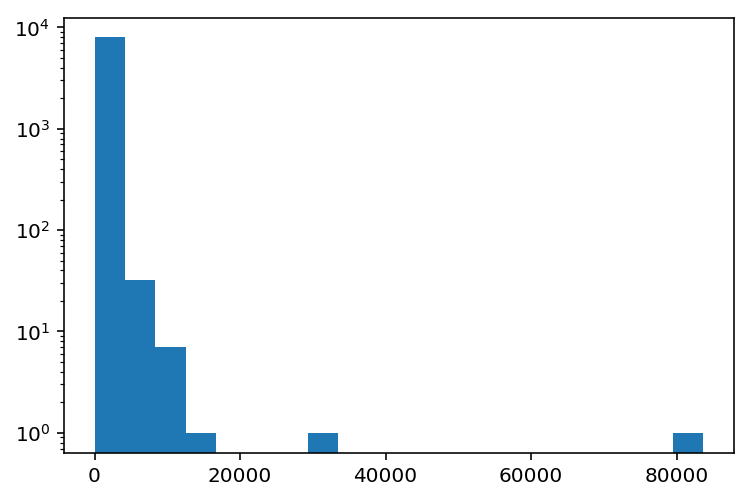

In [15]:
# Clearly quite a few outliers - have a look at how the price is spread in a histogram of prices, 20 bins.
plt.hist(listings.price, bins=20, log=True);

**Comment:** The histogram above is on a log-scale, showing a very skewed distribution of prices.  Not all may be real prices (> 80000 NOK per night (~10000 USD), and we do not need the outliers for our analysis. Will do two cleaning steps:
* Remove all listings that are not of type "Entire home/apt".
* Remove any listings with:
    * Price > 20000 NOK per night
    * Price < 200 NOK per night (after cleaning private/shared rooms).

In [16]:
# How is the distribution of room types?
listings.room_type.value_counts()

Entire home/apt    6410
Private room       1488
Shared room          84
Name: room_type, dtype: int64

In [17]:
# For more consistency in pricing, we will only look at listings of room type "Entire home/apt".
listings = listings[listings.room_type == 'Entire home/apt']

In [18]:
# Create a list of indexes to drop
drop_rows = list(listings_agg[listings_agg.price > 20000]['id']) + \
list(listings_agg[(listings_agg.price < 200) & (~listings_agg.room_type.isin(['Private room','Shared room']))]['id'])
drop_rows

[17577563, 24616982, 3334831, 9597602, 14287372, 19343407, 20485508, 22859614]

In [19]:
# Set the listings frame to all rows except the ones we decided to drop.
listings = listings[~listings['id'].isin(drop_rows)]

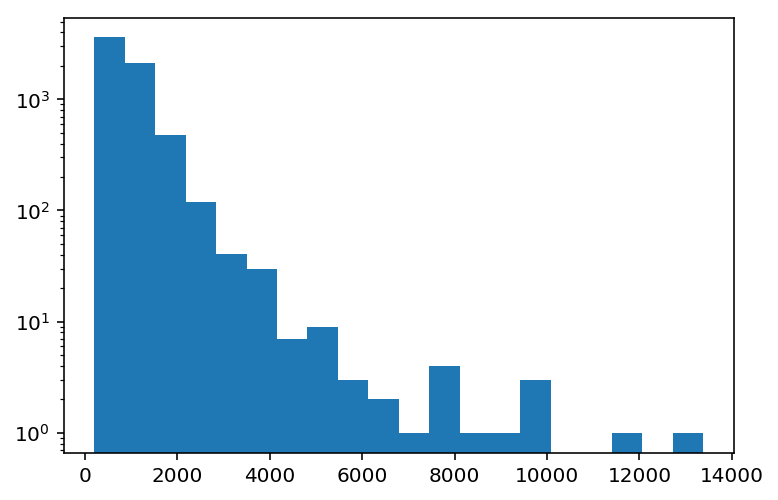

In [20]:
# Look at the prices after cleaning.
plt.hist(listings.price, bins=20, log=True);

**Comment:** The price-chart is still very skewed, but we got rid of the extreme outliers. Will keep it as such. But might suggest that when replacing null-values, medians are a better choice than means.

In [21]:
# What is the content of the amenities column?
listings['amenities'].head()

0    {TV,"Cable TV",Internet,Wifi,Kitchen,"Free str...
1    {TV,Wifi,"Air conditioning",Kitchen,Gym,"Pets ...
3    {TV,"Cable TV",Internet,Wifi,Kitchen,"Indoor f...
4    {TV,"Cable TV",Internet,Wifi,Kitchen,"Free par...
5    {TV,"Cable TV",Internet,Wifi,Kitchen,Elevator,...
Name: amenities, dtype: object

In [22]:
# Find the most common amenities.

# Create a list of lists - each amenity as a separate phrase.
amenities_lists = []
for item in list(listings['amenities']):
    amenities_lists.append(item.replace('{', '').replace('}','').replace('"','').split(','))
    
# Use a counter object to count occurences
counter = Counter(x for xs in amenities_lists for x in xs)

#Print the 90 most commmon amenities
counter.most_common(90)

[('Kitchen', 6330),
 ('Wifi', 6255),
 ('Heating', 6082),
 ('Washer', 5777),
 ('Essentials', 5764),
 ('Smoke detector', 5729),
 ('TV', 5366),
 ('Fire extinguisher', 5304),
 ('Iron', 4322),
 ('Hangers', 4257),
 ('Laptop friendly workspace', 4209),
 ('Hair dryer', 3882),
 ('Family/kid friendly', 3741),
 ('Shampoo', 3505),
 ('Cable TV', 2678),
 ('Dryer', 2571),
 ('Hot water', 2465),
 ('Internet', 2246),
 ('Buzzer/wireless intercom', 2142),
 ('Elevator', 2090),
 ('Indoor fireplace', 1739),
 ('Free parking on premises', 1713),
 ('Refrigerator', 1382),
 ('Dishes and silverware', 1357),
 ('First aid kit', 1354),
 ('Private entrance', 1354),
 ('Cooking basics', 1353),
 ('Stove', 1330),
 ('Oven', 1288),
 ('Bed linens', 1251),
 ('Dishwasher', 1218),
 ('Host greets you', 1092),
 ('Safety card', 1050),
 ('Lock on bedroom door', 1042),
 ('Pets allowed', 1009),
 ('Carbon monoxide detector', 900),
 ('Paid parking off premises', 875),
 ('Coffee maker', 854),
 ('Patio or balcony', 811),
 ('translation m

**Comment:** OK. WiFi will not set you apart. Let's use some common sense and intuition to derive a few extra features from the amenities column that might increase the price you can ask.

In [23]:
# Add new binary categoricals from the amenities
listings['has_parking'] = listings.amenities.str.contains('Free parking on premises|Paid parking on premises', case=False).astype(np.int8)
listings['has_tv'] = listings.amenities.str.contains('tv', case=False).astype(np.int8)
listings['has_washer'] = listings.amenities.str.contains('washer', case=False).astype(np.int8)
listings['has_iron'] = listings.amenities.str.contains('iron', case=False).astype(np.int8)
listings['has_hair_dryer'] = listings.amenities.str.contains('hair dryer', case=False).astype(np.int8)
listings['has_dryer'] = listings.amenities.str.contains('dryer', case=False).astype(np.int8)
listings['has_elevator'] = listings.amenities.str.contains('elevator', case=False).astype(np.int8)
listings['has_balcony'] = listings.amenities.str.contains('patio or balcony', case=False).astype(np.int8)
listings['has_fireplace'] = listings.amenities.str.contains('indoor fireplace', case=False).astype(np.int8)
listings['has_dishwasher'] = listings.amenities.str.contains('dishwasher', case=False).astype(np.int8)
listings['has_bathtub'] = listings.amenities.str.contains('bathtub', case=False).astype(np.int8)
listings['has_balcony'] = listings.amenities.str.contains('patio or balcony', case=False).astype(np.int8)
listings['has_microwave'] = listings.amenities.str.contains('microwave', case=False).astype(np.int8)
listings['has_balcony'] = listings.amenities.str.contains('patio or balcony', case=False).astype(np.int8)
listings['has_ac'] = listings.amenities.str.contains('air condition', case=False).astype(np.int8)
listings['has_gym'] = listings.amenities.str.contains('gym', case=False).astype(np.int8)

In [24]:
# Assessment of how much missing data there is in each column of thedataset.

# For easy plotting and visual inspection of values - 
# creating a small dataframe containing number of null values, number of non-null values and 
# percentage null values of total number of rows. Display descending by percentage.

df_missing_stats = pd.concat([listings.isnull().sum(), listings.count(), 
                              listings.isnull().sum() / listings.shape[0] * 100], axis=1)
df_missing_stats.columns = ['Number_of_nulls', 'Number_of_values', 'Percentage_null_of_total_rows']
df_missing_stats.sort_values(by=['Percentage_null_of_total_rows'], ascending=False).head(15)
df_missing_stats[df_missing_stats.Number_of_nulls != 0]

,Number_of_nulls,Number_of_values,Percentage_null_of_total_rows
name,22,6380,0.343643
summary,140,6262,2.186817
space,2858,3544,44.642299
description,63,6339,0.984067
neighborhood_overview,3277,3125,51.187129
notes,4733,1669,73.930022
transit,2815,3587,43.970634
access,3377,3025,52.749141
interaction,3718,2684,58.075601
house_rules,2508,3894,39.175258


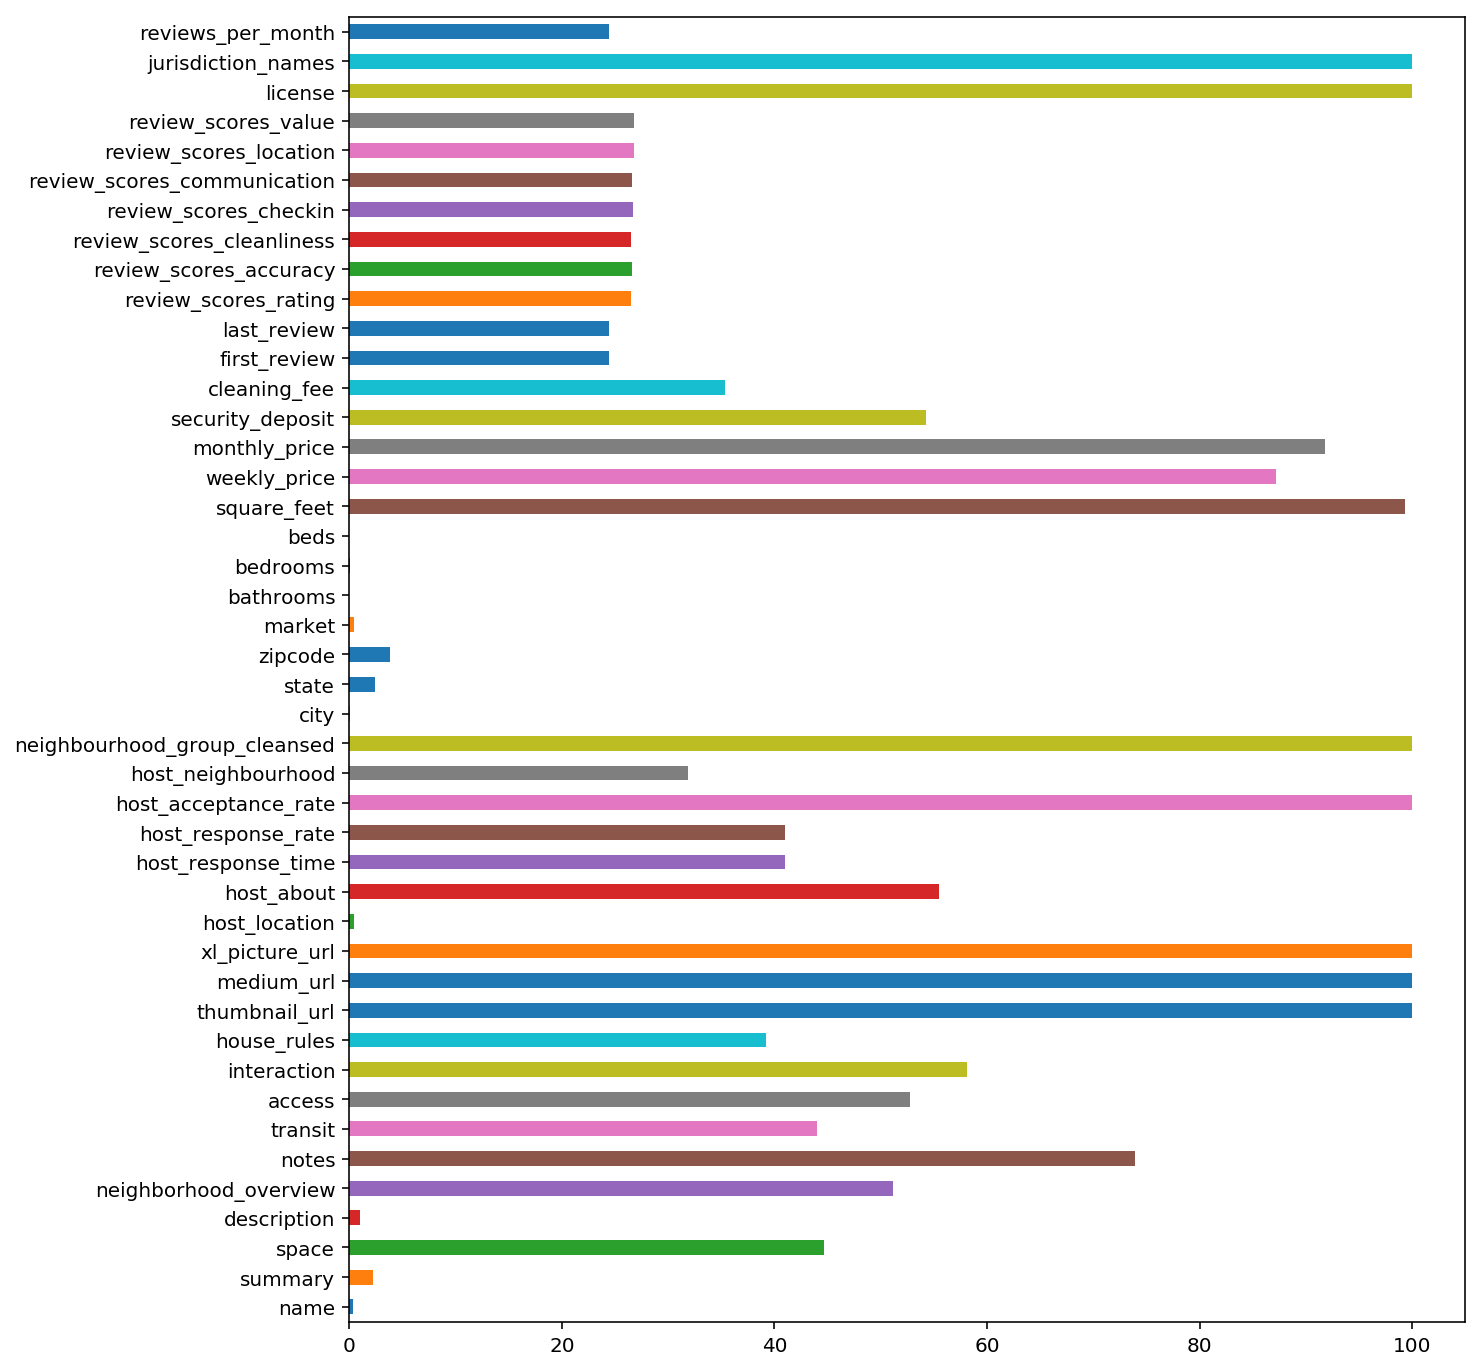

In [25]:
# View the percentage of null values of total visually
df_missing_stats[df_missing_stats.Number_of_nulls != 0]['Percentage_null_of_total_rows'].plot(kind='barh', figsize=(10,12));

Bins:
[  0  10  20  30  40  50  60  70  80  90 100 110]
Number of columns in each bin: 
[77.  0. 10.  3.  4.  5.  0.  1.  1.  2.  7.]


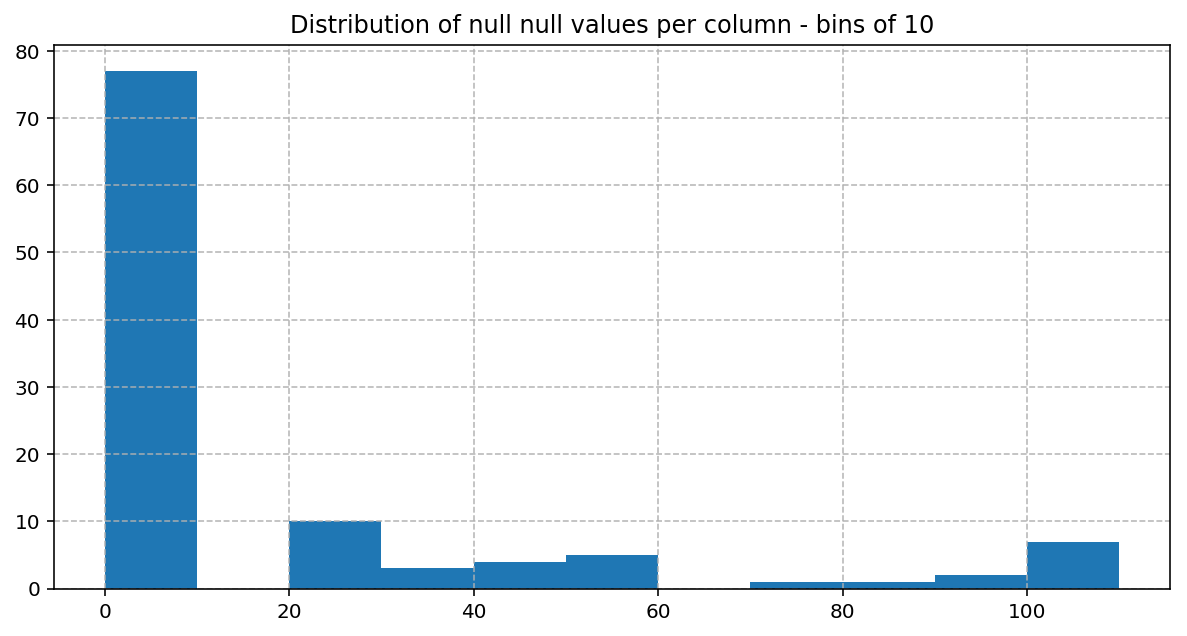

In [26]:
# Investigate patterns in the amount of missing data in each column.
# Histogram shows distribution (number of columns per share of)
f, axs = plt.subplots(1,1,figsize=(10,5))
bins = [i for i in range(0,111,10)]

(n, bins, patches) = plt.hist(df_missing_stats.Percentage_null_of_total_rows, bins=bins)
print('Bins:')
print(bins)
print('Number of columns in each bin: ')
print(n)
plt.grid(which='both',alpha=0.9, linestyle='--')
plt.title('Distribution of null null values per column - bins of 10')
plt.show()

In [27]:
# Although the host_response_rate contains many null values, it can probably be assumed that the null values actually mean
# zero - i.e. no response received..
print(listings.host_response_rate.isnull().sum() + listings[listings.host_response_rate == '0%'].shape[0])
listings['host_response_rate'] = listings.host_response_rate.str.strip('%').fillna(0).astype(int)
print(listings[listings.host_response_rate == 0].shape[0])

2673
2673


In [28]:
# Drop all columns with more than 30% null values
null_cols = listings.loc[:,listings.isnull().sum()/listings.shape[0] > 0.2].any(axis=0).index.tolist()
keep_cols = [col for col in list(listings) if col not in null_cols]
listings = listings[keep_cols]

In [29]:
# View dropped columns
null_cols

['space',
 'neighborhood_overview',
 'notes',
 'transit',
 'access',
 'interaction',
 'house_rules',
 'thumbnail_url',
 'medium_url',
 'xl_picture_url',
 'host_about',
 'host_response_time',
 'host_acceptance_rate',
 'host_neighbourhood',
 'neighbourhood_group_cleansed',
 'square_feet',
 'weekly_price',
 'monthly_price',
 'security_deposit',
 'cleaning_fee',
 'first_review',
 'last_review',
 'review_scores_rating',
 'review_scores_accuracy',
 'review_scores_cleanliness',
 'review_scores_checkin',
 'review_scores_communication',
 'review_scores_location',
 'review_scores_value',
 'license',
 'jurisdiction_names',
 'reviews_per_month']

In [30]:
# View columns of dtype "object", as these are probably categorical columns
listings.select_dtypes(include=['object']).columns.tolist()

['listing_url',
 'last_scraped',
 'name',
 'summary',
 'description',
 'experiences_offered',
 'picture_url',
 'host_url',
 'host_name',
 'host_since',
 'host_location',
 'host_is_superhost',
 'host_thumbnail_url',
 'host_picture_url',
 'host_verifications',
 'host_has_profile_pic',
 'host_identity_verified',
 'street',
 'city',
 'state',
 'zipcode',
 'market',
 'smart_location',
 'country_code',
 'country',
 'is_location_exact',
 'property_type',
 'room_type',
 'bed_type',
 'amenities',
 'extra_people',
 'calendar_updated',
 'has_availability',
 'calendar_last_scraped',
 'requires_license',
 'instant_bookable',
 'is_business_travel_ready',
 'cancellation_policy',
 'require_guest_profile_picture',
 'require_guest_phone_verification',
 'neighbourhood']

In [31]:
# View some interesting columns.
print(listings['host_since'].value_counts().head())
print(listings['extra_people'].value_counts().head())

2017-10-23    275
2017-05-04     27
2016-10-04     27
2016-02-15     25
2015-06-24     17
Name: host_since, dtype: int64
$0.00      3738
$200.00     550
$100.00     539
$150.00     370
$250.00     202
Name: extra_people, dtype: int64


In [32]:
# Convert some columns to numeric: extra people, host_days
listings['host_days'] = (pd.Timestamp.now() - pd.to_datetime(listings.host_since)).dt.days
listings['extra_people'] = listings.extra_people.str.replace('[$|,]', '').astype(np.float32)

In [33]:
# Drop the categorical columns that I will not use for either machine learning or visualization.

# List of categorical columns I want to keep
keep_categoricals = ['neighbourhood', 'host_identity_verified','property_type', 'cancellation_policy','host_is_superhost']

# list of all columns from the list above (columns of type object), except the ones in keep_categoricals
drop_categoricals = set(listings.select_dtypes(include=['object']).columns.tolist()).difference(set(keep_categoricals))

# Set the listings frame to all columns except the catgorical columns to be dropped.
listings = listings[[col for col in list(listings) if col not in drop_categoricals]]

In [34]:
listings.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6402 entries, 0 to 7980
Data columns (total 44 columns):
id                                6402 non-null int64
scrape_id                         6402 non-null int64
host_id                           6402 non-null int64
host_response_rate                6402 non-null int32
host_is_superhost                 6402 non-null object
host_listings_count               6402 non-null int64
host_total_listings_count         6402 non-null int64
host_identity_verified            6402 non-null object
latitude                          6402 non-null float64
longitude                         6402 non-null float64
property_type                     6402 non-null object
accommodates                      6402 non-null int64
bathrooms                         6401 non-null float64
bedrooms                          6399 non-null float64
beds                              6401 non-null float64
guests_included                   6402 non-null int64
extra_people    

In [35]:
# Encode the t/f binary values in the dataset to 0s and 1s.
listings['host_is_superhost'] = listings.host_is_superhost.apply(lambda x: 0 if x=='f' else 1)
listings['host_identity_verified'] = listings.host_identity_verified.apply(lambda x: 0 if x=='f' else 1)

**Comment:** Keeping the rest of the categorical columns for now - will use neighbourhood for plotting on maps. The plan is:
* Use neighbourhood for plotting on maps
* Encode the neighbourhood columns as an numeric ordinal categorical feature, for easy correlation plotting.
* Later - binary encode the categorical columns, so that we are left with only numeric non-null values.

In [36]:
# There are few null values left, the amount is so small that it would likely not introduce any bias to impute.
# Will just fill with medians and convert to an int to save some memory..
for col in list(listings):
    if listings[col].isnull().any():
        listings[col] = listings[col].fillna(listings[col].median())

## Data analysis - neighbourhoods - number of listings and prices
Before we move in to the machine learning part - analyze number of listings and prices

Text(0.5,1,'Areas with most listings')

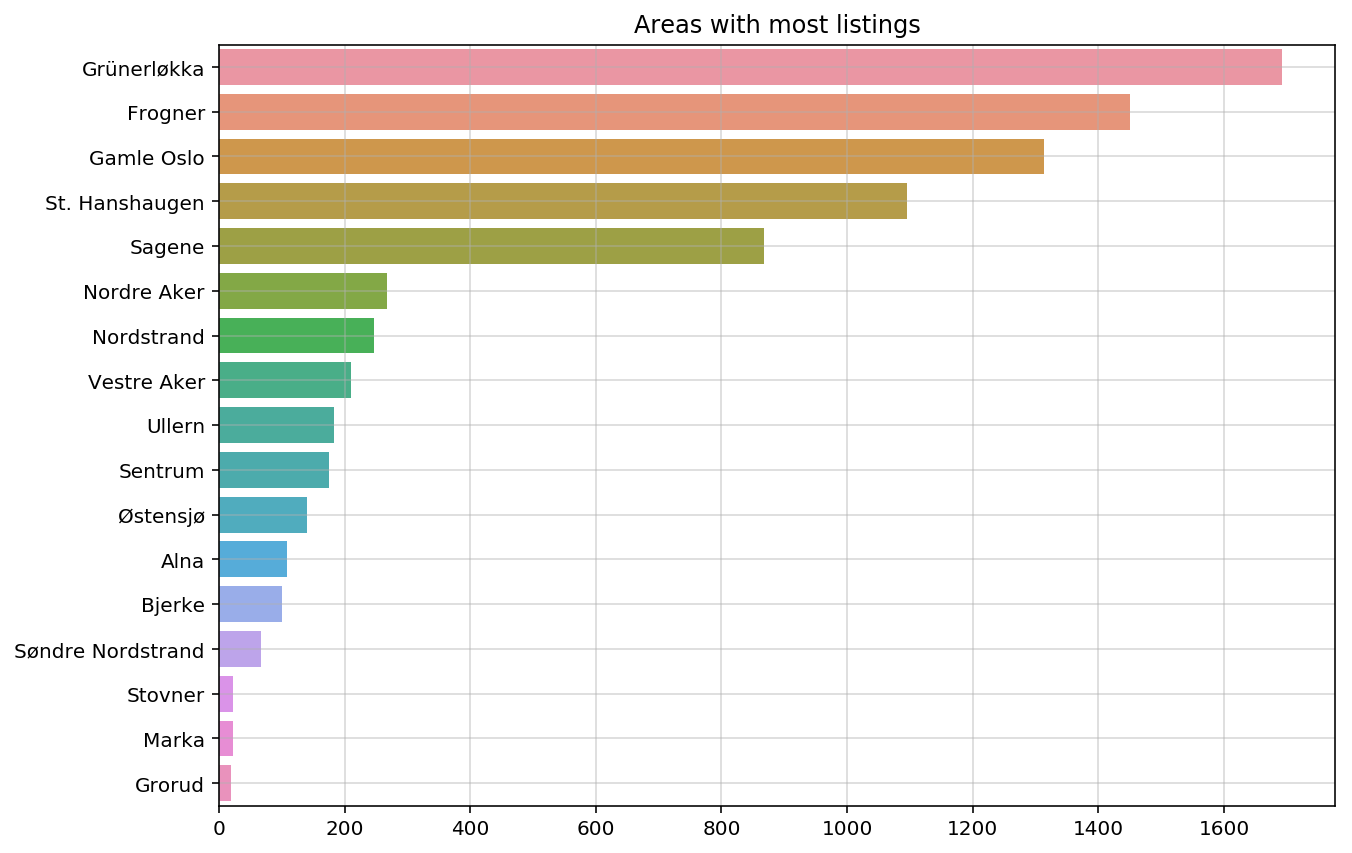

In [37]:
# Create a bar-chart showing the number of listings withing each neighbourhood.
plt.subplots(1,1, figsize=(10,7))
x = listings_agg.neighbourhood.value_counts().index
y = listings_agg.neighbourhood.value_counts().values
ax = sns.barplot(x=y, y=x)
plt.grid(alpha=0.5)
plt.title('Areas with most listings')

**Comment:** Looks like 5 neighbourhoods have the lions share of listings - where are these on the map, and how does the details look?

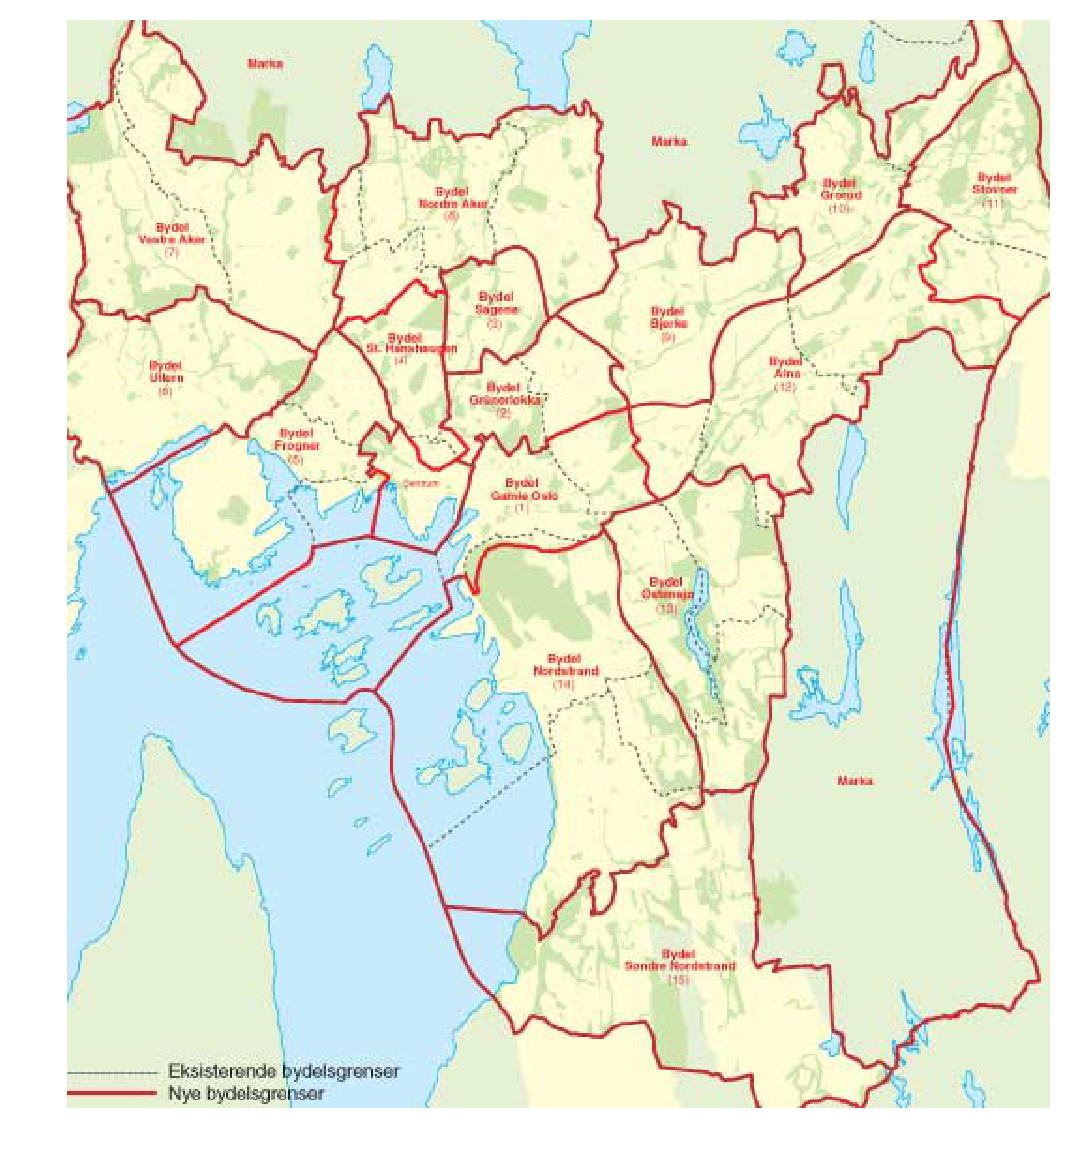

In [38]:
# View a map of the city
plt.subplots(figsize=(10,10))
img=mpimg.imread('./img/neighbourhoods_oslo.jpeg')
imgplot = plt.imshow(img)
plt.axis('off');

**Comment:** All the top 5 are close to the city center. Logical, but nice to see on a map anyways.  Now how does it look if we plot every coordinate in the listings on a map of Oslo?

In [39]:
# Set a variable to point to the geojson file.
oslo_geo = os.path.join('./data', 'neighbourhoods_utf.geojson')

In [40]:

# Create a new folium map, centered over Oslo
oslo_map_2 = folium.Map(location=[59.912336, 10.723842],
                        zoom_start=10,
                        tiles='CartoDB positron')

# Set coordinate values to all lat/long values in dataframe
coordinates = listings[['latitude', 'longitude']].values

# Add a heatmap to the map
oslo_map_2.add_child(plugins.HeatMap(coordinates, radius=10))

# Add borough border lines to the map
folium.GeoJson(
    oslo_geo
    ,style_function=lambda x: {
        'weight' : 0.8,
        'opacity': 1,
        'fillOpacity' : 0.
        }
).add_to(oslo_map_2)


# Save the map to disk for screenshots.
oslo_map_2.save('./html/heatmap.html')

oslo_map_2

**Comment:** This view gives a little more detail, and we can see that there are clusters of apartments for rent in the middle of Oslo centrum (Sentrum) as well as in the outskirts to the east (Østensjø), and that specific areas within each borough have high numbers of Airbnb listings, such as for example Majorstua, north in the Frogner borough.

Next, let's try to get some insight into the price statistics of Airbnb as well as official housing prices in Oslo.

In [41]:
# Some statistics on prices within neighbourhoods below.
listings.groupby('neighbourhood')['price'].agg(['mean','median','min','max','count'])

,mean,median,min,max,count
neighbourhood,,,,,
Alna,716.967742,627.5,326,2000,62
Bjerke,833.463768,661.0,368,5004,69
Frogner,1143.373847,954.0,201,8986,1193
Gamle Oslo,972.364082,803.0,268,9497,1019
Grorud,906.142857,904.0,452,1498,7
Grünerløkka,875.875640,787.0,284,5004,1367
Marka,940.117647,1004.0,251,2100,17
Nordre Aker,906.922727,782.5,301,2502,220
Nordstrand,1094.512563,904.0,251,3899,199


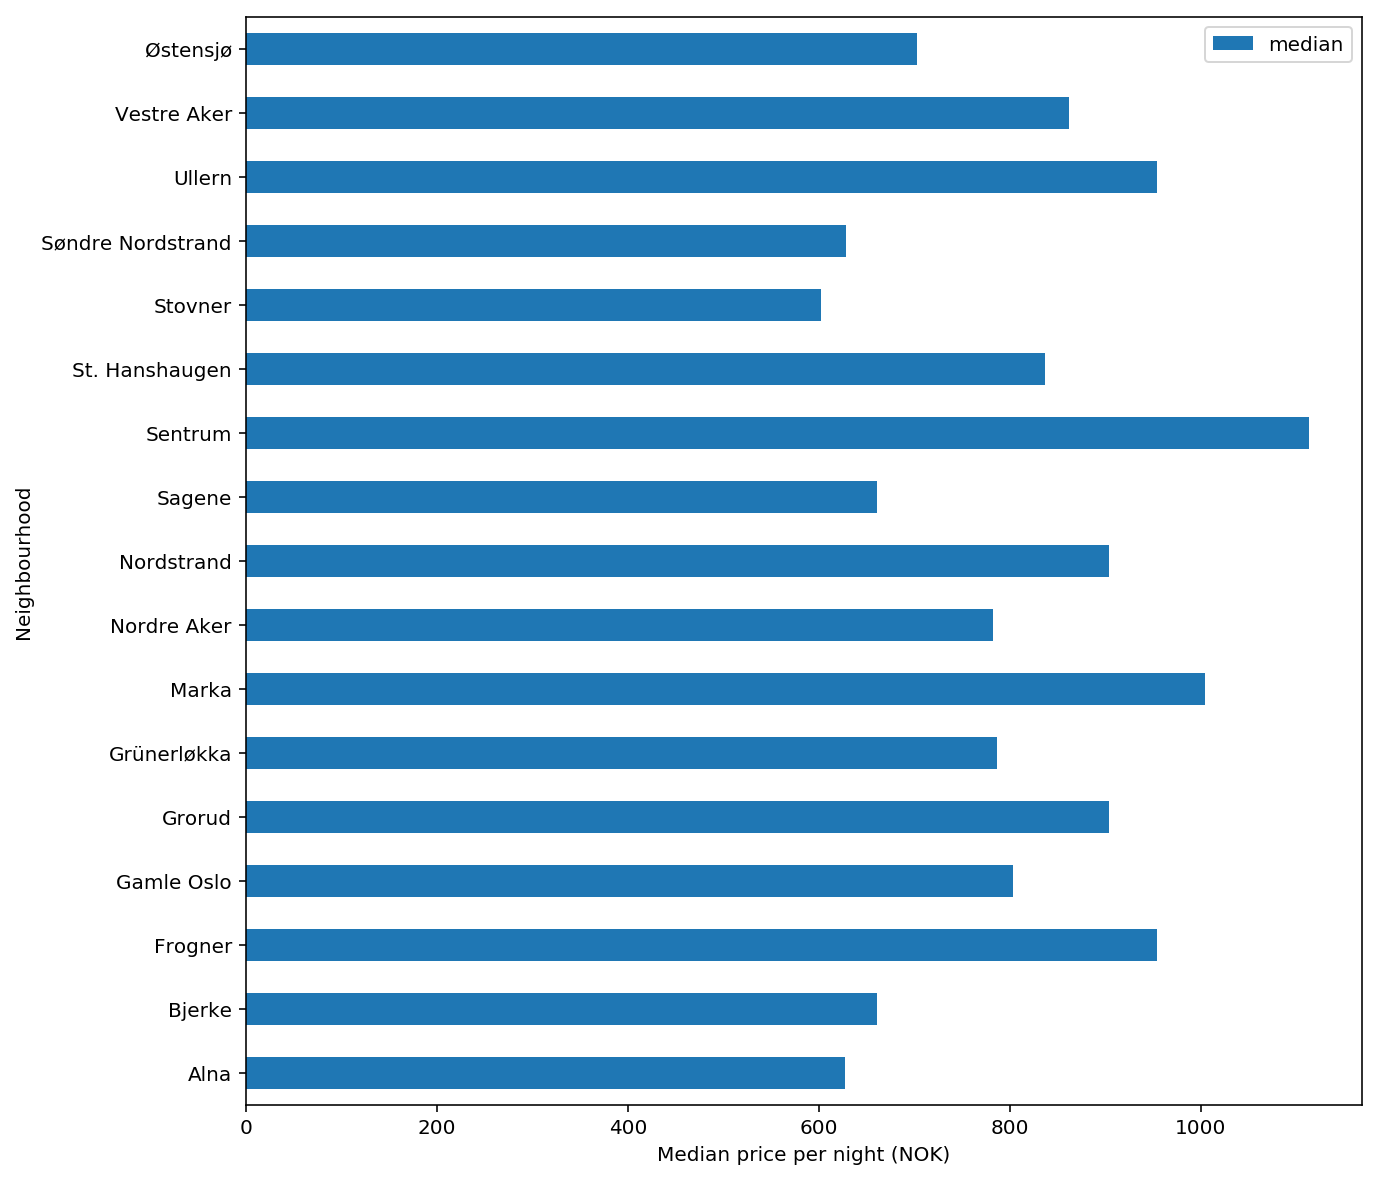

In [42]:
# View it visually in a bar chart.
axs = listings.groupby('neighbourhood')['price'].agg(['median']).plot(kind='barh', figsize=(10,10));
axs.set_xlabel('Median price per night (NOK)')
axs.set_ylabel('Neighbourhood');

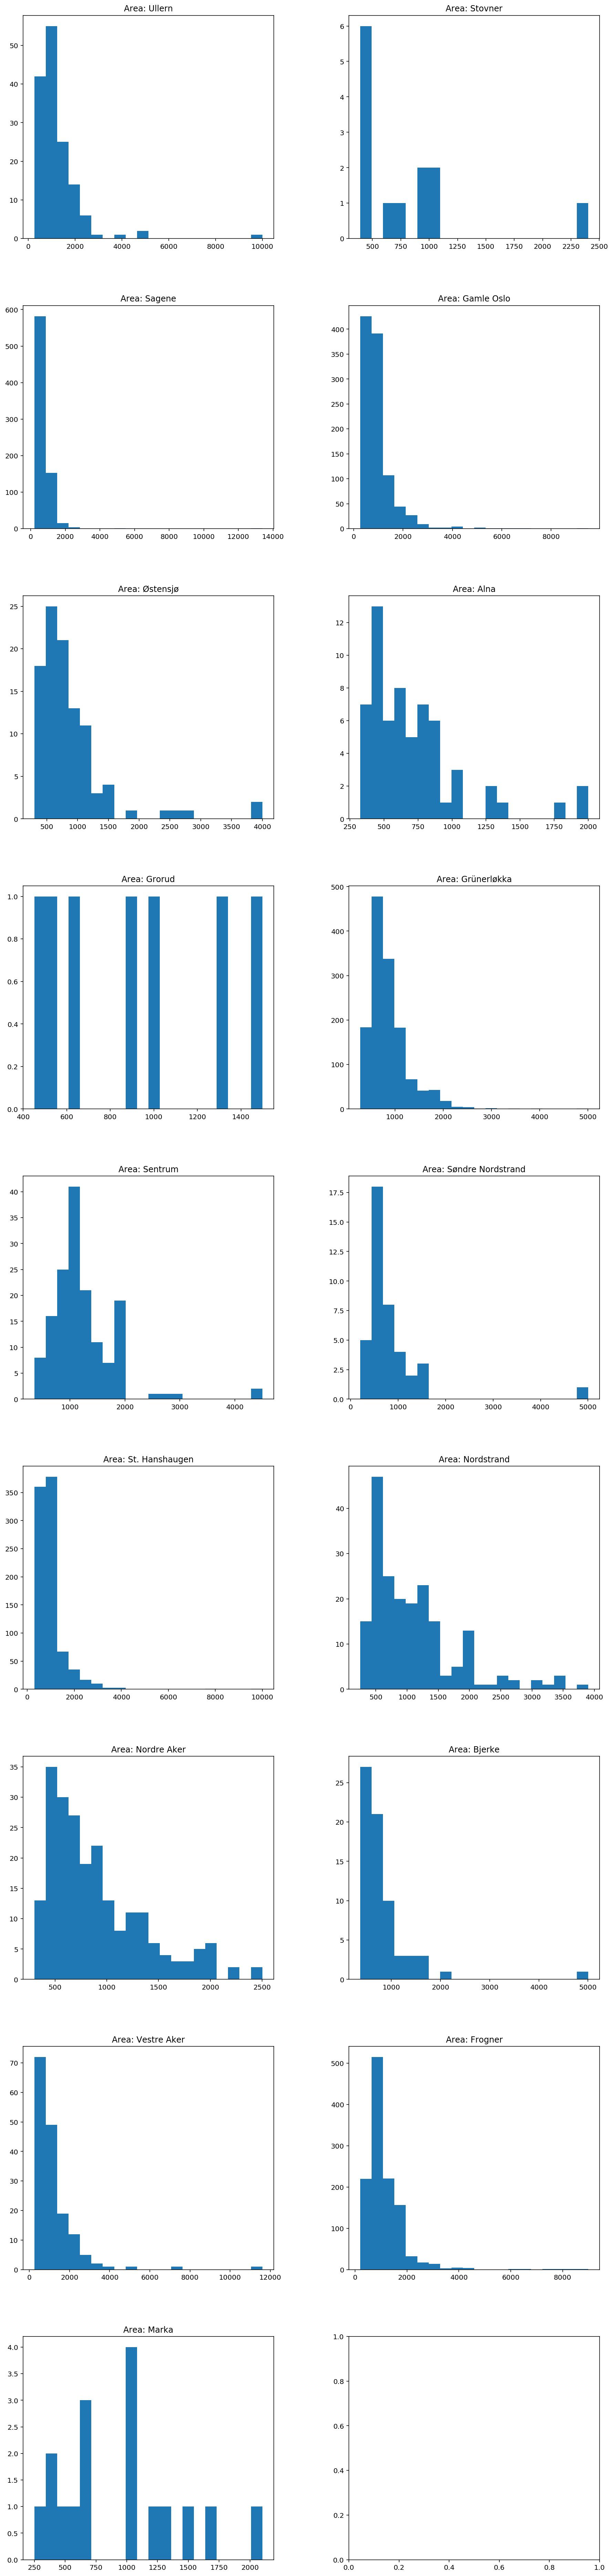

In [43]:
# Take a look at the price distributions within each neighborhood - are they all skewed like for Oslo as a whole?
areas = set(listings.neighbourhood.values)
num_areas = len(areas)

f, axs = plt.subplots(ceil(num_areas / 2 ),2,figsize=(15,4*num_areas))
plt.subplots_adjust(hspace = 0.3)
plt.subplots_adjust(wspace = 0.3)

x = []
y = []

for i, col in enumerate(areas):
    row = i // 2
    column = i%2
    n, bins, patches = axs[row,column].hist(listings[listings.neighbourhood == col].price.values, bins=20)
    axs[row,column].set_title('Area: {}'.format(col))
    axs[row,column].set_xticklabels(bins, fontdict=None, minor=True)


**Comment:** As for Oslo as a whole, the prices are quite skewed.

In [44]:
# Create a dataframe of official housing price statistics in Oslo
neighbourhood_price_df = html_to_df('./data/price_stats_raw.html')

In [45]:
# Add the neighbourhood official price statistics to the listings dataframe and drop redundant columns
listings = listings.merge(neighbourhood_price_df, left_on='neighbourhood', right_on='neighbourhood', how='left')

In [46]:
# Create a folium map, centered over Oslo
oslo_map = folium.Map(location=[59.912336, 10.723842],
                        zoom_start=10,
                        tiles='CartoDB positron')

# Add coloring to show official housing prices
oslo_map.choropleth(
 geo_data=oslo_geo,
 name='choropleth',
 data=neighbourhood_price_df,
 columns=['neighbourhood', 'avg_price_per_m2'],
 key_on='properties.neighbourhood',
 fill_color='BuPu',
 fill_opacity=0.7,
 line_opacity=0.2,
 threshold_scale=[40000, 50000, 60000, 70000, 80000, 90000],
 legend_name='Average price per m2'
)

# Save html version
oslo_map.save('./html/offical_prices.html')

# View map
oslo_map



**Comment:** The housing prices are highest on the Oslo west side, near the center - as expected. How does the Airbnb prices look on the same map?

In [47]:
# Create a helper frame for Airbnb price statistics.
neighbourhood_prices = listings.groupby('neighbourhood')['price'].agg(['mean','median','min','max','count'])
neighbourhood_prices = neighbourhood_prices.reset_index()

In [48]:
# Create a new folium map, centered over Oslo
oslo_map_3 = folium.Map(location=[59.912336, 10.723842],
                        zoom_start=10,
                        tiles='CartoDB positron')


# Add colors to the boroghus, according to Airbnb prices.
oslo_map_3.choropleth(
 geo_data=oslo_geo,
 name='choropleth',
 data=neighbourhood_prices,
 columns=['neighbourhood', 'median'],
 key_on='properties.neighbourhood',
 fill_color='BuPu',
 fill_opacity=0.7,
 line_opacity=0.2,
 threshold_scale=[n for n in range(600,1200,100)],
 legend_name='Median price per night'
)


oslo_map_3.save('./html/airbnb_median_prices_map.html')
# Show the map
oslo_map_3


**Comment:** The city center seem to have the highest prices, although the western boroughs of Frogner and Ullern also have high median values.  The "Marka" areas to the north and east are basically forest areas with very few listings that are not really representative of Oslo as a whole.

Does this mean that neighbourhood is a factor that has high correlation with price? Time to be more techincal.

# Data analysis - ML part

In [49]:
# Clean the rest of the columns that I will not need for the statistics part.
non_ml_cols = ['id', 'scrape_id', 'host_id', 'latitude', 'longitude', 'neighbourhood','avg_price_per_m2']
listings = listings[[col for col in list(listings) if col not in non_ml_cols]]

In [50]:
listings = pd.get_dummies(listings, drop_first=True);

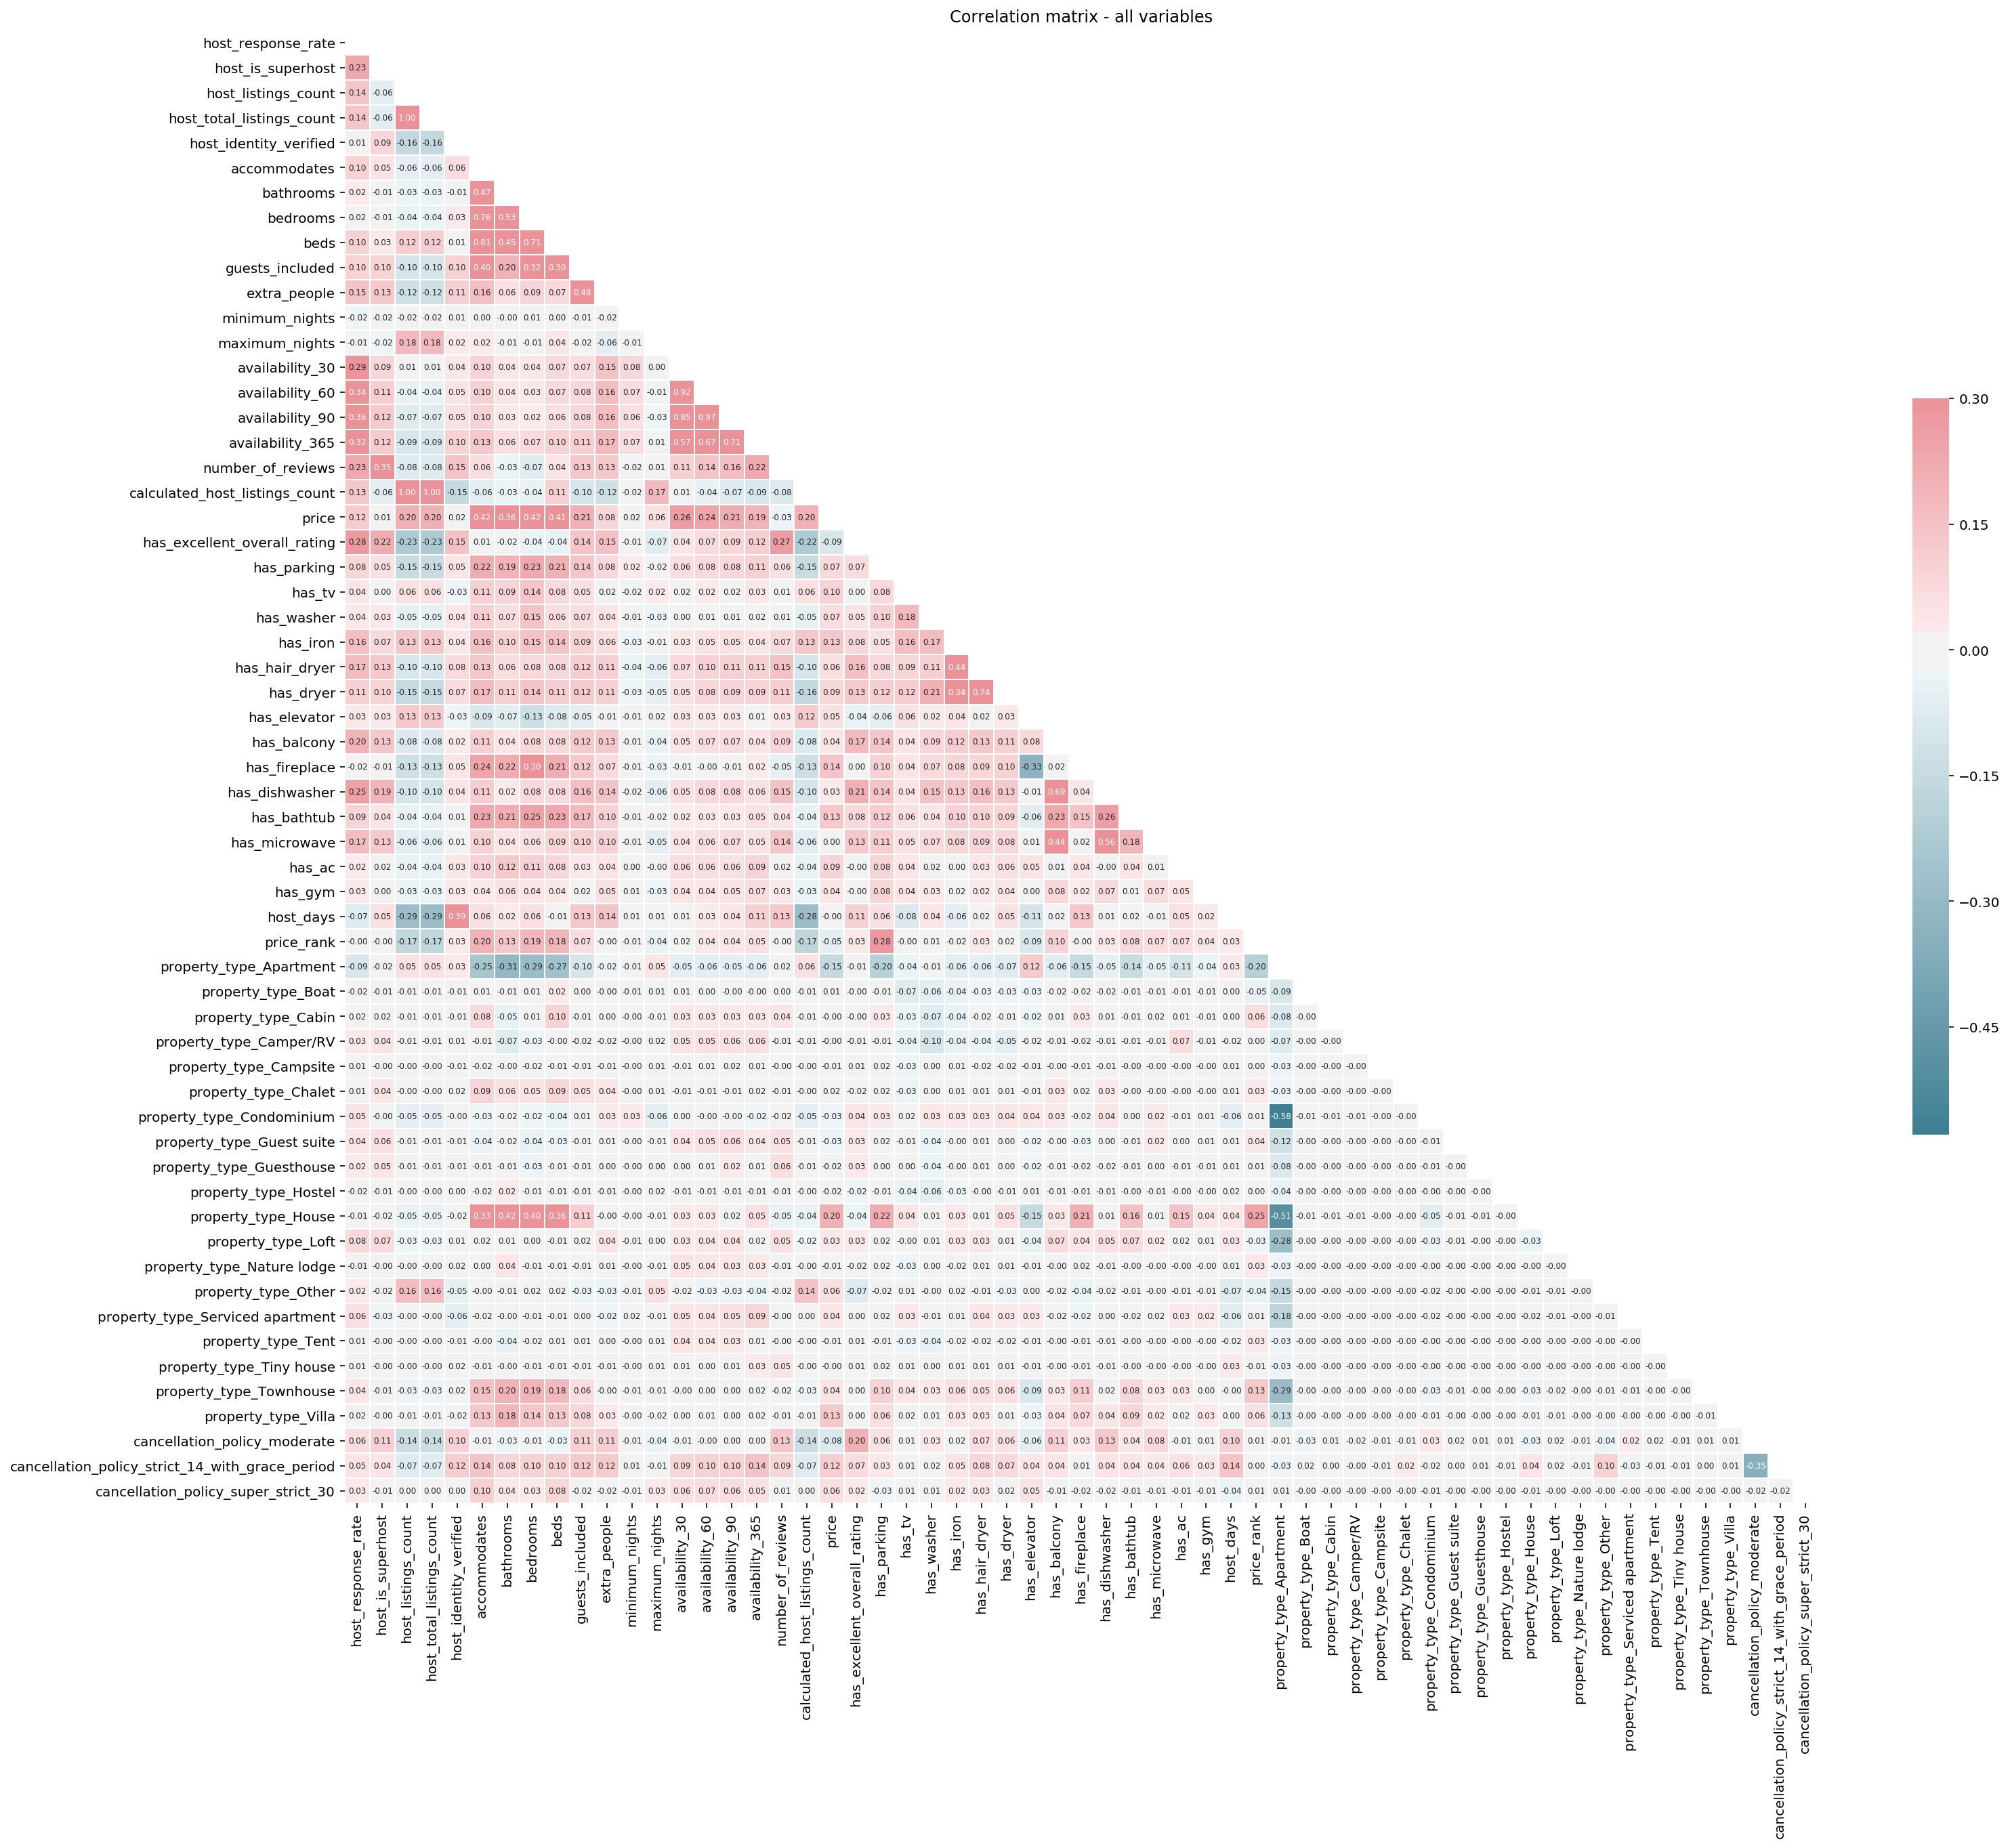

In [51]:
def plot_correlation_matrix(df, title='Correlation matrix'):
    """
    Simple function to plot a correlation matrix for a dataframe.
    """
    # Compute the correlation matrix
    corr = df.corr()

    # Generate a mask for the upper triangle
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    fig, ax = plt.subplots(figsize=(25,20))

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True, fmt='.2f', annot_kws={"size": 6})
    
    plt.title(title)

plot_correlation_matrix(listings, 'Correlation matrix - all variables')

**Comment:** OK, you need good eyes, or download the exported png version of this heatmap, but it does give some interesting insights:
* There are many columns with high correlation that seem to capture the same latent features, e.g.:
    * Bedrooms, bathrooms, beds - all highly correlated with accomodates - the bigger the property, the more beds and the more people can be accomodated.
    * Property types house, villa, townhouse and accommodates (and bed/bath) - same as above.
    * Amenities - correlates with each other, suggesting that maybe these users simply take the time to fill out more details on the listing.
    * Availability columns naturally have a very high correlation.
    * Number of listing columns are perfectly correlated
* Price does not correlate with price_rank at all - the official housing prices.  So if you want to do Airbnb as an investment- do not buy property in the highest priced areas...
* Price correlates the most with how many people the property can accomodate.
* Price also correlates with number of listings.. do "pros" get better prices?

Based on this, I will remove some of the highly correlated features as well as do two experiments trying to predict price:
1. Keeping all the one-hot encoded columns
2. Removing the property type one-hot encoded columns and making a "is_house" binary feature instead.

In [52]:
# Remove the most obvious correlated features and create the dataframe for the first experiment
remove_correlated = ['availability_60', 'availability_90', 'availability_365',
                     'bedrooms', 'beds', 'calculated_host_listings_count', 'host_listings_count']
listings_v1  = listings[[col for col in list(listings) if col not in remove_correlated]]

In [53]:
# Create the dataframe for the second experiment
listings_v2 = listings_v1.copy()
listings_v2['is_house'] = listings_v2.property_type_House + listings_v2.property_type_Villa + listings_v2.property_type_Townhouse

In [54]:
# Drop all the one-hot encoded property columns.
listings_v2.drop([col for col in list(listings_v2) if col.startswith('property_')], axis=1, inplace=True)

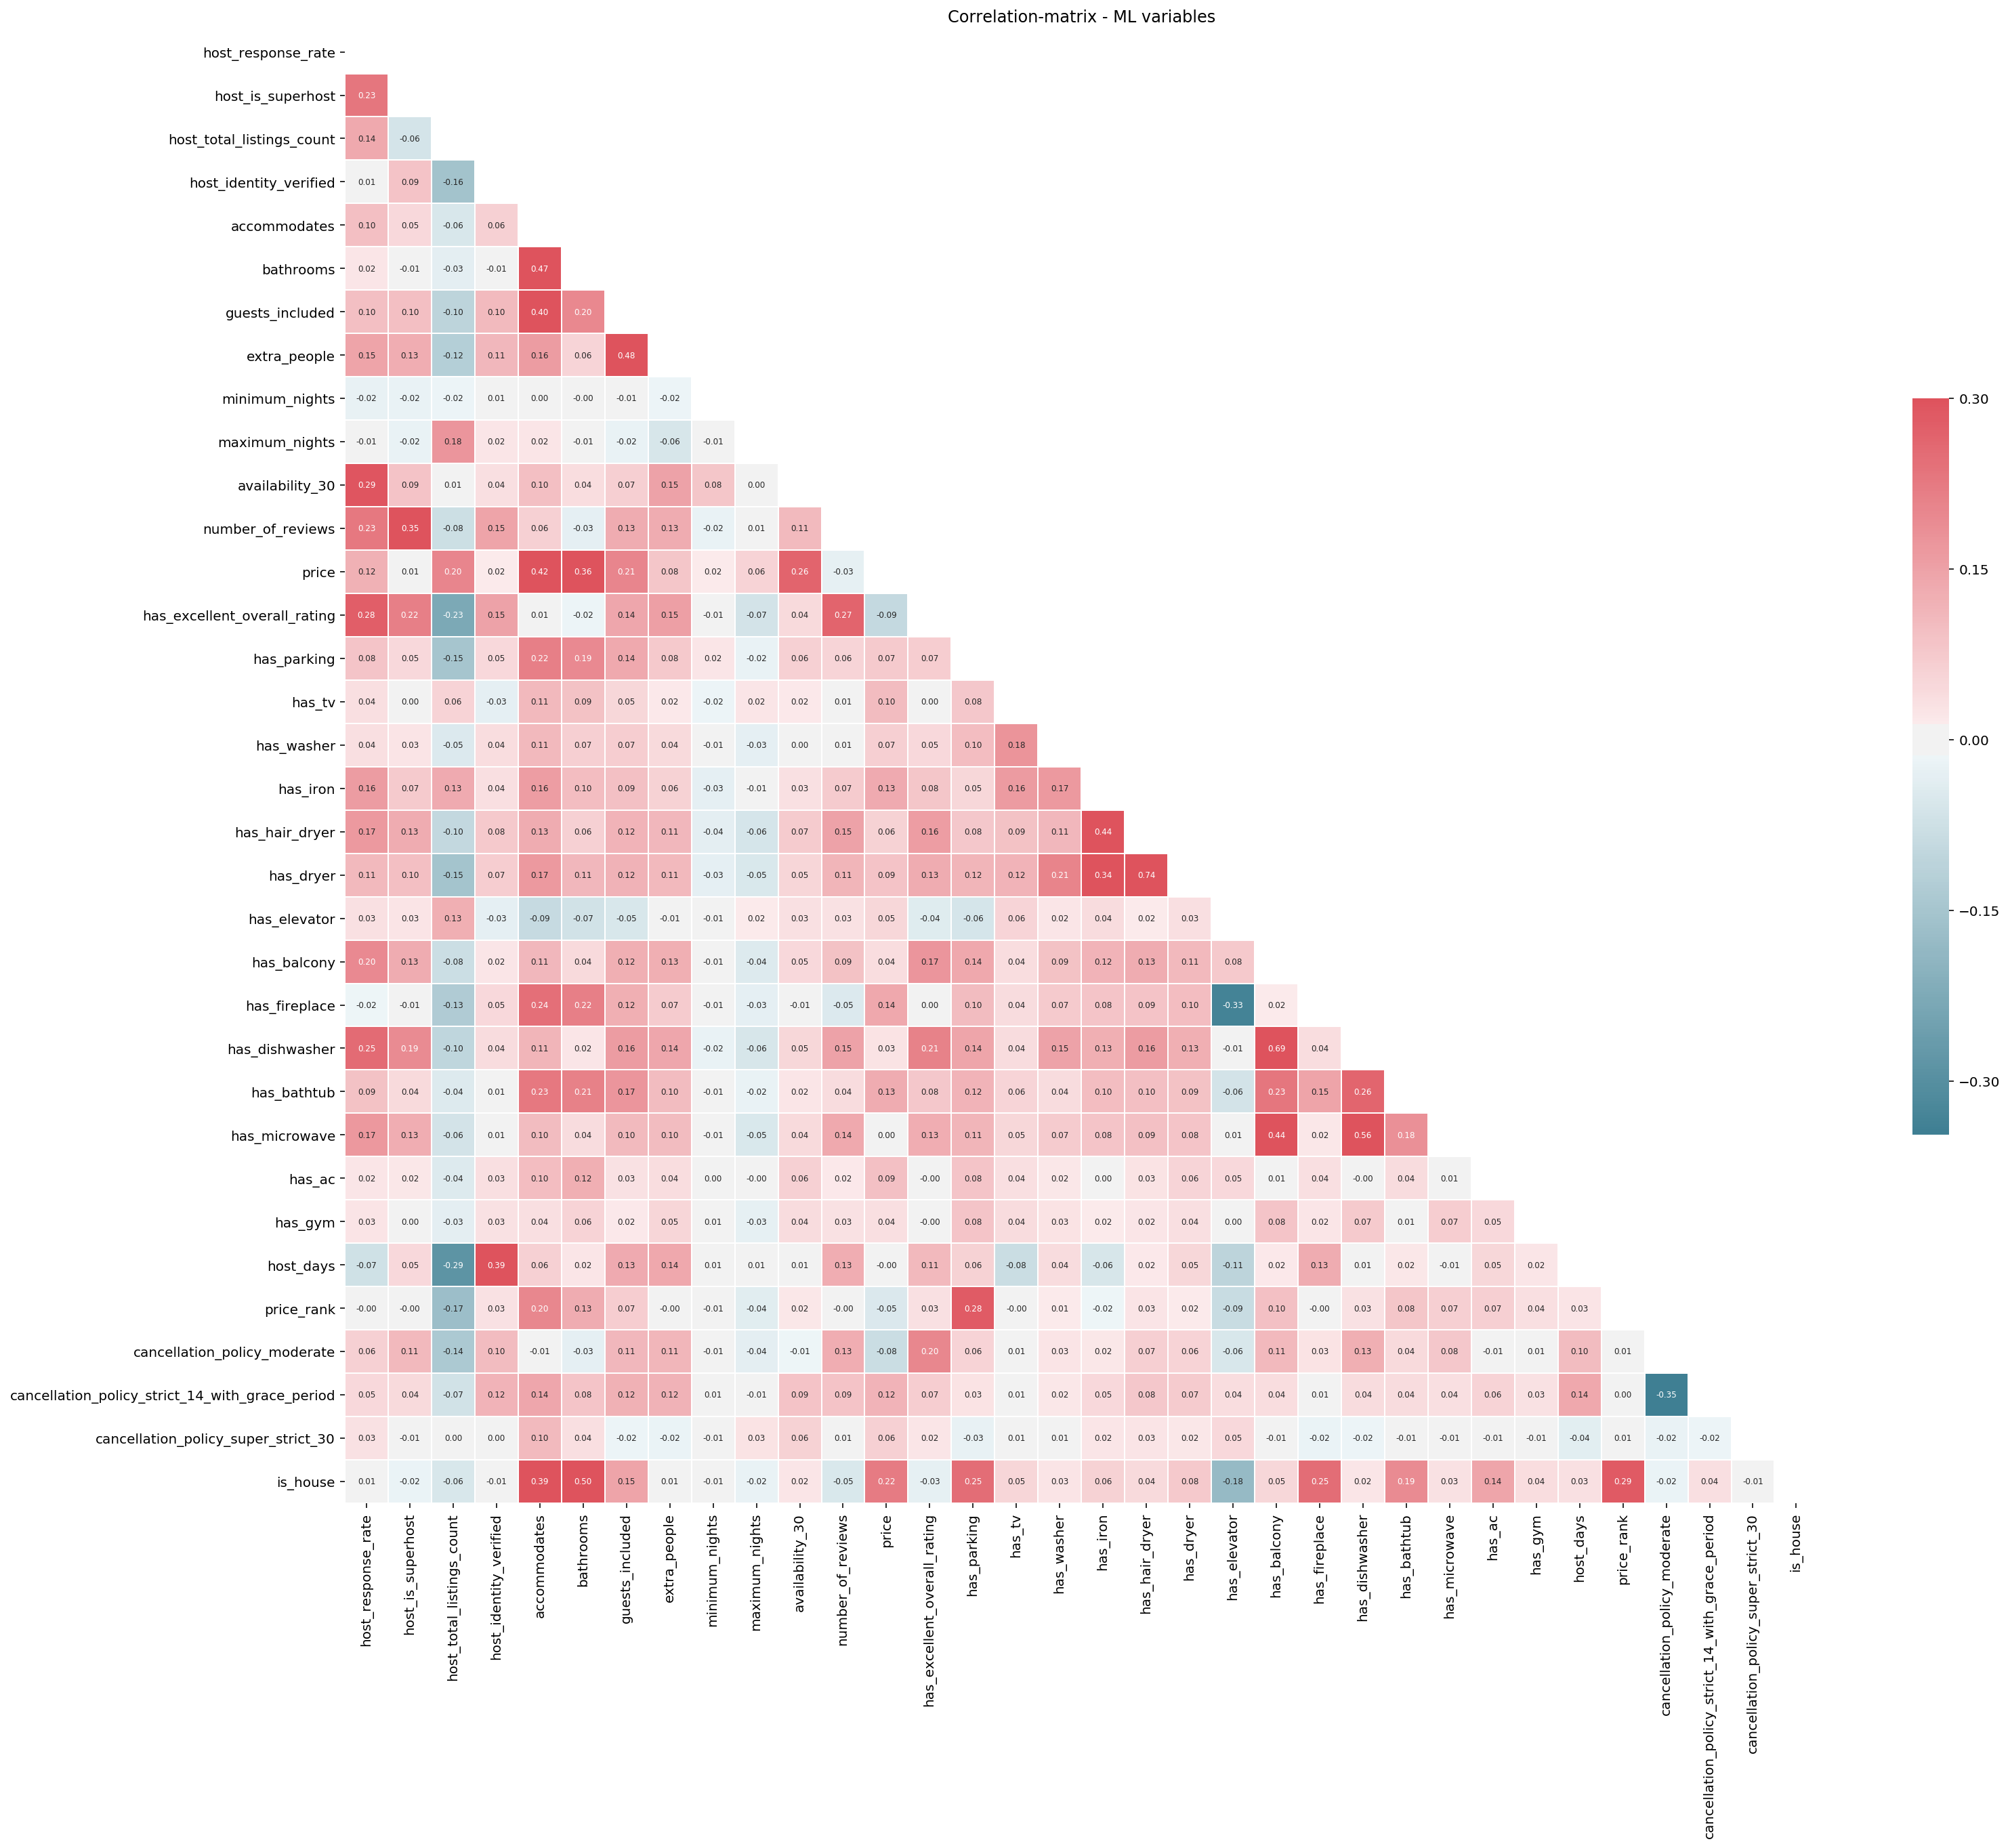

In [55]:
# Plot a new correlation matrix for the blog
plot_correlation_matrix(listings_v2, 'Correlation-matrix - ML variables')

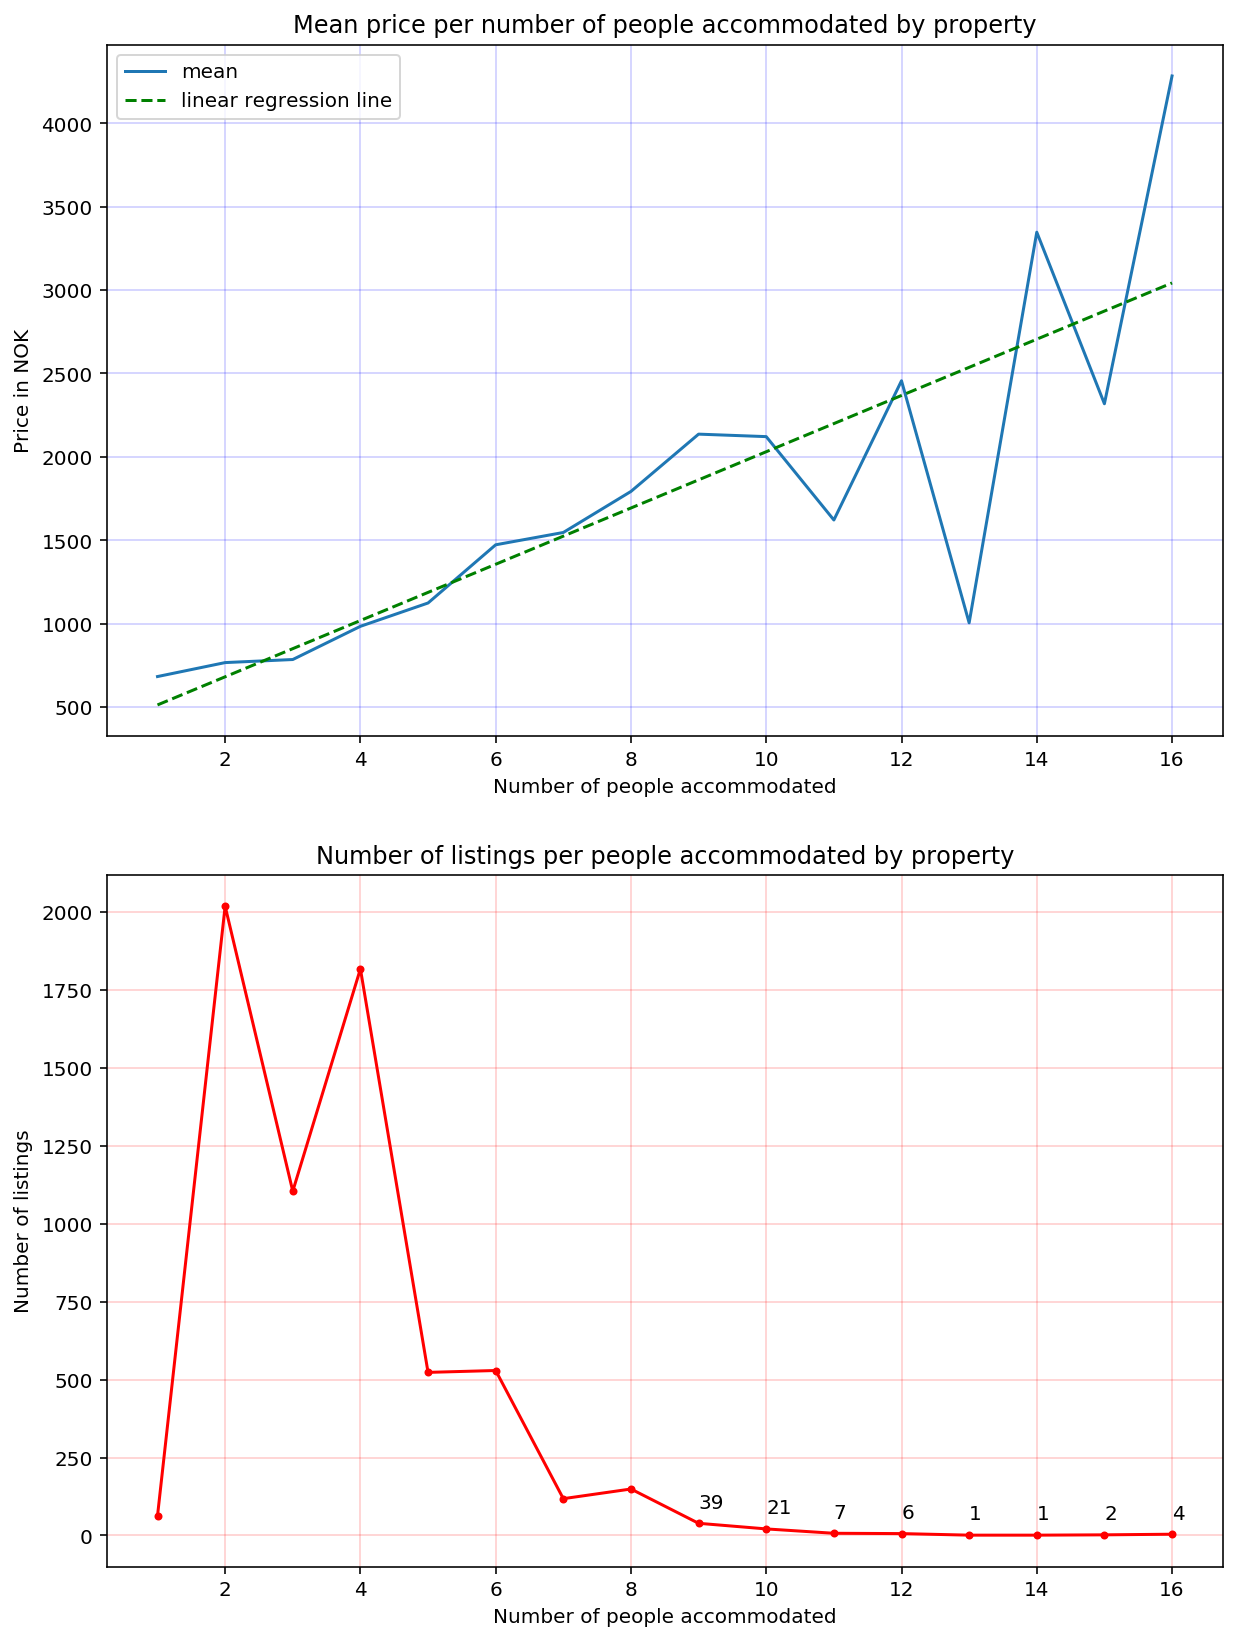

In [56]:
# Accommodates have the highest correlation with price, look closer at this
f, ax = plt.subplots(2,1,figsize=(10,14))

# Create the numbers to plot
accommodates_df = listings_v2.groupby('accommodates')['price'].agg(['count', 'mean'])

# For easy plotting, extract index and series
x = accommodates_df.index
y1 = accommodates_df['mean']
y2 = accommodates_df['count']

# Create a regression line
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y1)
line = slope*x+intercept

# Plot the first subplot -  mean price per number of people accommodated
ax[0].plot(x,y1)
ax[0].grid(alpha=0.2,which='both', color='b')

ax[0].set_title('Mean price per number of people accommodated by property')
ax[0].set_ylabel('Price in NOK')
ax[0].set_xlabel('Number of people accommodated')
equation = 'y={:.2f}x+{:.2f}'.format(slope,intercept)
ax[0].plot(x, line, 'g', linestyle='--',label='linear regression line')
ax[0].legend()

# Plot the second subplot - number of listings per number of people accommodated
ax[1].plot(x,y2, color='r',marker='.')
ax[1].grid(alpha=0.2,which='both', color='r')
ax[1].set_title('Number of listings per people accommodated by property')
ax[1].set_ylabel('Number of listings')
ax[1].set_xlabel('Number of people accommodated')

# Add values to the lower values of number of people accommodated
for i,j in zip(x,y2):
    if i >= 9:
        ax[1].annotate(str(j),xy=(i,j+50));


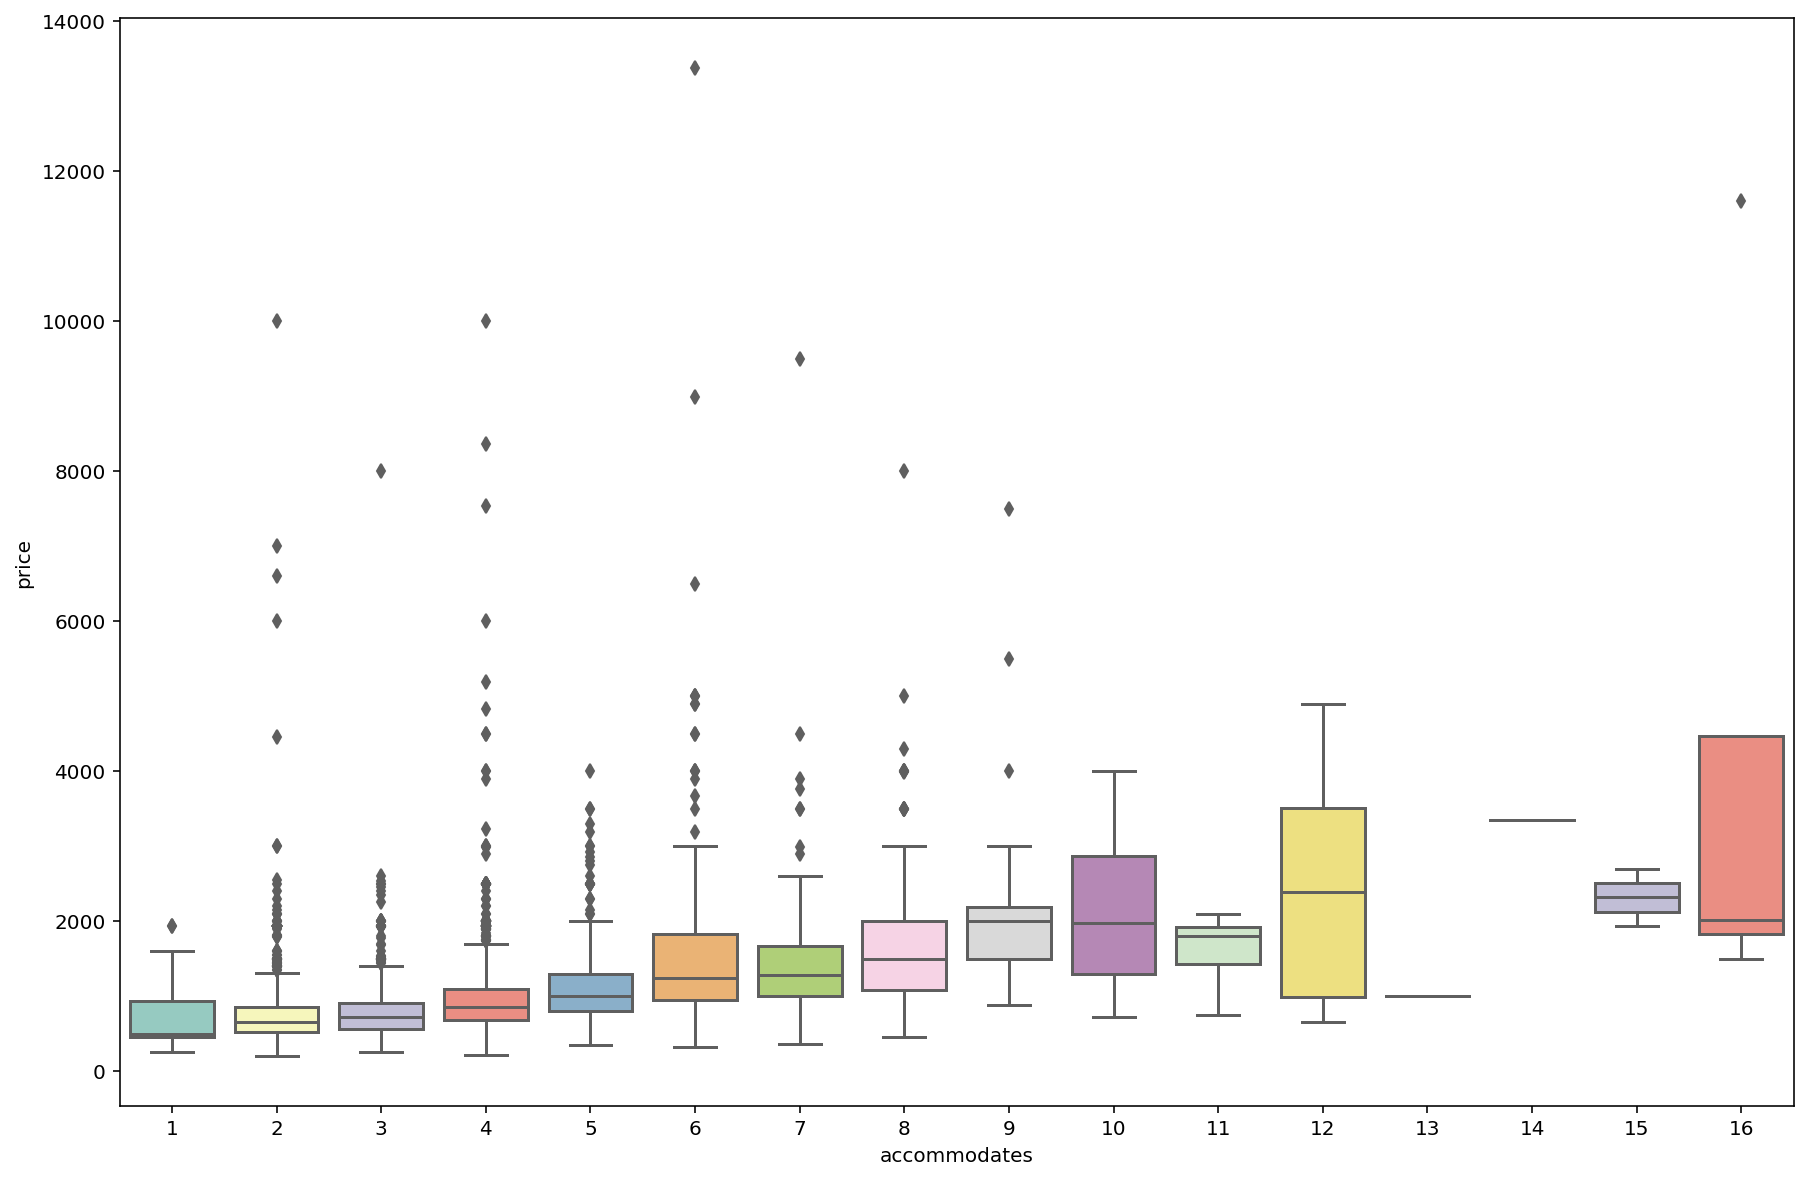

In [57]:
# View some more details on price and accommodates.
plt.subplots(1,1,figsize=(15,10))
ax = sns.boxplot(x="accommodates", y="price",  data=listings, palette="Set3")

In [58]:
# Split the targets
targets = listings_v1['price']
listings_v1 = listings_v1[[col for col in list(listings_v1) if col != 'price']]
listings_v2 = listings_v2[[col for col in list(listings_v2) if col != 'price']]

In [59]:
# Split to training set and testing sets
X_train_v1, X_test_v1, y_train_v1, y_test_v1 = \
train_test_split(listings_v1, targets, test_size=0.3, random_state = 0)

X_train_v2, X_test_v2, y_train_v2, y_test_v2 = \
train_test_split(listings_v2, targets, test_size=0.3, random_state = 0)


# Apply feature scaling to the two versions
scaler_v1 = StandardScaler()
scaler_v2 = StandardScaler()
scaler_model_v1 = scaler_v1.fit(X_train_v1)
scaler_model_v2 = scaler_v2.fit(X_train_v2)

X_train_v1_sc = pd.DataFrame(scaler_model_v1.transform(X_train_v1), index=X_train_v1.index, columns=X_train_v1.columns)
X_train_v2_sc = pd.DataFrame(scaler_model_v2.transform(X_train_v2), index=X_train_v2.index, columns=X_train_v2.columns)
X_test_v1_sc = pd.DataFrame(scaler_model_v1.transform(X_test_v1), index=X_test_v1.index, columns=X_test_v1.columns)
X_test_v2_sc = pd.DataFrame(scaler_model_v2.transform(X_test_v2), index=X_test_v2.index, columns=X_test_v2.columns)

In [60]:
def search_ada_model(X_train, y_train, param_dist):
    """
    Do a randomized search on training set.
    Purpose of function is only to avoid repeating code.
    """
    
    ada_model = RandomizedSearchCV(AdaBoostRegressor(), 
                                   param_distributions = param_dist, cv=5, n_iter = 50, n_jobs=4, verbose=10, random_state=0);
    ada_model.fit(X_train, y_train)
    
    return ada_model

In [61]:
parameters = {
 'n_estimators': [50,75,100,150,200,250],
 'learning_rate' : [0.01, 0.03, 0.1, 0.3, 1.],
 'loss' : ['linear', 'square', 'exponential']
 }


ada_model_v1 = search_ada_model(X_train_v1, y_train_v1, parameters)
ada_scaled_model_v1 = search_ada_model(X_train_v1_sc, y_train_v1, parameters)

ada_model_v2 = search_ada_model(X_train_v2, y_train_v2, parameters)
ada_scaled_model_v2 = search_ada_model(X_train_v2_sc, y_train_v2, parameters)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    4.4s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    5.4s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:   11.1s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:   12.7s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:   16.1s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   18.3s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:   23.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:   27.3s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:   33.4s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:   36.9s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:   41.9s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:   45.3s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:   49.1s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:   55.7s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:  1.0min
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  1.1min
[Parallel(n_jobs=4)]: Do

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    4.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    5.1s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:   11.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:   13.1s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:   15.8s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   17.7s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:   22.9s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:   26.7s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:   32.1s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:   35.1s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:   39.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:   42.0s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:   44.9s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:   50.6s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:   56.2s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  1.0min
[Parallel(n_jobs=4)]: Do

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    3.7s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    4.5s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    8.6s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:   10.2s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:   12.2s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   14.2s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:   17.9s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:   21.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:   26.1s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:   28.3s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:   31.8s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:   34.4s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:   37.5s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:   42.7s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:   47.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   51.4s
[Parallel(n_jobs=4)]: Do

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    3.7s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    4.8s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:   10.3s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:   12.1s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:   14.2s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   16.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:   20.5s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:   23.8s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:   28.8s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:   31.1s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:   35.3s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:   38.4s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:   40.9s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:   46.4s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:   50.8s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   55.2s
[Parallel(n_jobs=4)]: Do

In [62]:
# Make predictions for all of the models
ada_v1_predicted = ada_model_v1.predict(X_test_v1)
ada_scaled_v1_predicted = ada_scaled_model_v1.predict(X_test_v1_sc)
ada_v2_predicted = ada_model_v2.predict(X_test_v2)
ada_scaled_v2_predicted = ada_scaled_model_v2.predict(X_test_v2_sc)

In [63]:
# Check RMSE for all predictions.
print('Un-scaled V1: {}'.format(sqrt(mean_squared_error(y_test_v1, ada_v1_predicted))))
print('Scaled V1: {}'.format(sqrt(mean_squared_error(y_test_v1, ada_scaled_v1_predicted))))
print('-------------')
print('Un-scaled V2: {}'.format(sqrt(mean_squared_error(y_test_v2, ada_v2_predicted))))
print('Scaled V2: {}'.format(sqrt(mean_squared_error(y_test_v2, ada_scaled_v2_predicted))))
print('Y mean: {}'.format(y_test_v2.mean()))

Un-scaled V1: 503.4731928215944
Scaled V1: 502.65499358664346
-------------
Un-scaled V2: 501.8742612969048
Scaled V2: 505.37486879020105
Y mean: 948.7157730348777


**Comment:** The performance is not impressive.  From the correlation matrix, it seems that the accomodates by far correlates the most with price. The price is very skewed, so let's try to log transform the dependent variable and run AdaboostRegressor on that.  In addition, some of the amenities might be more harm than good for the algorithm since they also correlate with accomodates (e.g. has_fireplace =big place = accomodates more people). Try again by removing some of the amenities columns.

In [64]:
# Base version 3 on version 2.
listings_v3 = listings_v2.copy()

# Re-encode the neighbourhoods (represented by the ordinal price_rank) as one-hot encoced variables.
listings_v3 = pd.get_dummies(listings_v3,  columns=['price_rank'])

listings_v3.drop([col for col in list(listings_v3) if ((col.startswith('has_')) & 
                  (col not in ['has_tv', 'has_iron', 'has_bathtub']))], axis=1, inplace=True)

In [65]:
# Log transform the target variable
log_targets = np.log1p(targets)

In [66]:
# Create train/test splits of version3
X_train_v3_lt, X_test_v3_lt, y_train_v3_lt, y_test_v3_lt = \
train_test_split(listings_v3, log_targets, test_size=0.3, random_state = 0)

# Try with both scaled and unchanged independent variables.
scaler_v2 = StandardScaler()
scaler_model_v1 = scaler_v1.fit(X_train_v3_lt)

X_train_v3_ltsc = pd.DataFrame(scaler_model_v1.transform(X_train_v3_lt), 
                               index=X_train_v3_lt.index, columns=X_train_v3_lt.columns)
X_test_v3_ltsc = pd.DataFrame(scaler_model_v1.transform(X_test_v3_lt), 
                              index=X_test_v3_lt.index, columns=X_test_v3_lt.columns)


In [67]:
# Fit scaled and unscaled versions with log-transformed target variable
ada_model_v3_lt = search_ada_model(X_train_v3_lt, y_train_v3_lt, parameters)
ada_model_v3_ltsc = search_ada_model(X_train_v3_ltsc, y_train_v3_lt, parameters)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    3.7s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    4.6s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    9.9s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:   11.9s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:   14.1s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   15.7s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:   20.2s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:   23.5s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:   28.7s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:   31.2s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:   35.5s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:   38.0s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:   40.9s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:   46.4s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:   51.2s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   58.1s
[Parallel(n_jobs=4)]: Do

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    3.5s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    4.3s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    8.8s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:   10.6s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:   12.6s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   14.3s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:   17.9s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:   21.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:   26.2s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:   28.4s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:   33.6s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:   36.0s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:   38.7s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:   43.9s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:   48.6s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   54.1s
[Parallel(n_jobs=4)]: Do

In [68]:
# Predict and print results
ada_model_v3_lt_predicted = ada_model_v3_lt.predict(X_test_v3_lt)
ada_model_v3_ltsc_predicted = ada_model_v3_ltsc.predict(X_test_v3_ltsc)

print('Log-transformed targets V3: {}'.format(sqrt(mean_squared_error(np.expm1(y_test_v3_lt),
                                                                               np.expm1(ada_model_v3_lt_predicted)))))

print('Log-transformed targets V3: {}'.format(sqrt(mean_squared_error(np.expm1(y_test_v3_lt),
                                                                               np.expm1(ada_model_v3_ltsc_predicted)))))

Log-transformed targets V3: 501.09080810024597
Log-transformed targets V3: 500.3014267901436


**Comment:** The transformation efforts only resultied in marginally better performance.  Perhaps to many features have been dropped in the cleaning process? Anyway, let's try a couple of other algorithms.

In [69]:
# Try ridge regression with some different alpha values, both on scaled and non-scaled values
ridge_model = linear_model.RidgeCV(alphas=[0.01,0.03, 0.1, 0.3, 1.0, 3, 10.0], cv=10, normalize=True)
ridge_model.fit(X_train_v3_lt, y_train_v3_lt)

ridge_model_sc = linear_model.RidgeCV(alphas=[0.01,0.03, 0.1, 0.3, 1.0, 3, 10.0], cv=10)
ridge_model_sc.fit(X_train_v3_ltsc, y_train_v3_lt)

RidgeCV(alphas=[0.01, 0.03, 0.1, 0.3, 1.0, 3, 10.0], cv=10,
    fit_intercept=True, gcv_mode=None, normalize=False, scoring=None,
    store_cv_values=False)

In [70]:
# Predict and print result of ridge regression
ridge_predicted = ridge_model.predict(X_test_v3_lt)
ridge_predicted_sc = ridge_model_sc.predict(X_test_v3_ltsc)

print('Log-transformed V3 ridge: {}'.format(sqrt(mean_squared_error(np.expm1(y_test_v3_lt),
                                                                               np.expm1(ridge_predicted)))))

print('Log-transformed V3 ridge scaled: {}'.format(sqrt(mean_squared_error(np.expm1(y_test_v3_lt),
                                                                               np.expm1(ridge_predicted_sc)))))

Log-transformed V3 ridge: 484.5417102120544
Log-transformed V3 ridge scaled: 485.07418624505556


In [71]:
# Try elastic net regression with some different alpha values
elasticnet_model = linear_model.ElasticNetCV(cv=10, random_state=0,alphas=[0.01,0.03, 0.1, 0.3, 1.0, 3, 10.0])
elasticnet_model.fit(X_train_v3_lt, y_train_v3_lt)

ElasticNetCV(alphas=[0.01, 0.03, 0.1, 0.3, 1.0, 3, 10.0], copy_X=True, cv=10,
       eps=0.001, fit_intercept=True, l1_ratio=0.5, max_iter=1000,
       n_alphas=100, n_jobs=1, normalize=False, positive=False,
       precompute='auto', random_state=0, selection='cyclic', tol=0.0001,
       verbose=0)

In [72]:
# Predict and print result of elastic net regression
elasticnet_predicted = elasticnet_model.predict(X_test_v3_lt)
print('Log-transformed V3 elnet: {}'.format(sqrt(mean_squared_error(np.expm1(y_test_v3_lt),
                                                                               np.expm1(elasticnet_predicted)))))

Log-transformed V3 elnet: 495.8432479192708


**Comment:** Turns out a simpler ridge regression improves on the AdaboostRegressor, but the RMSE values are still not very impressive, with an RMSE of 484 for a range of test targets with mean 948.  Test a RandomForrestRegressor last..

In [73]:
# Search parameters
param_dist = {"max_depth":[3,5,7],
              "n_estimators" : [100, 200, 400, 500],
              "min_samples_split": [2,4,6,8,10],
              "bootstrap": [True, False],
              "min_samples_leaf" : [2,4,6,8,10]
             }

# Search for parameters and fit model to data
rf_model = RandomizedSearchCV(RandomForestRegressor(), 
                                 param_distributions=param_dist, n_iter=10, cv=10, verbose=10, n_jobs=4, random_state=0)
rf_model.fit(X_train_v3_lt, y_train_v3_lt);

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:   11.5s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:   16.6s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:   23.7s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:   26.2s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:   35.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   47.4s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:   55.4s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:  1.0min
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:  1.3min
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:  1.6min
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:  1.8min finished


In [74]:
# Make predictions and print results
rf_predictions = rf_model.predict(X_test_v3_lt)
print('Log-transformed V3 random forrest: {}'.format(sqrt(mean_squared_error(np.expm1(y_test_v3_lt),
                                                                               np.expm1(rf_predictions)))))

Log-transformed V3 random forrest: 476.33716103617024


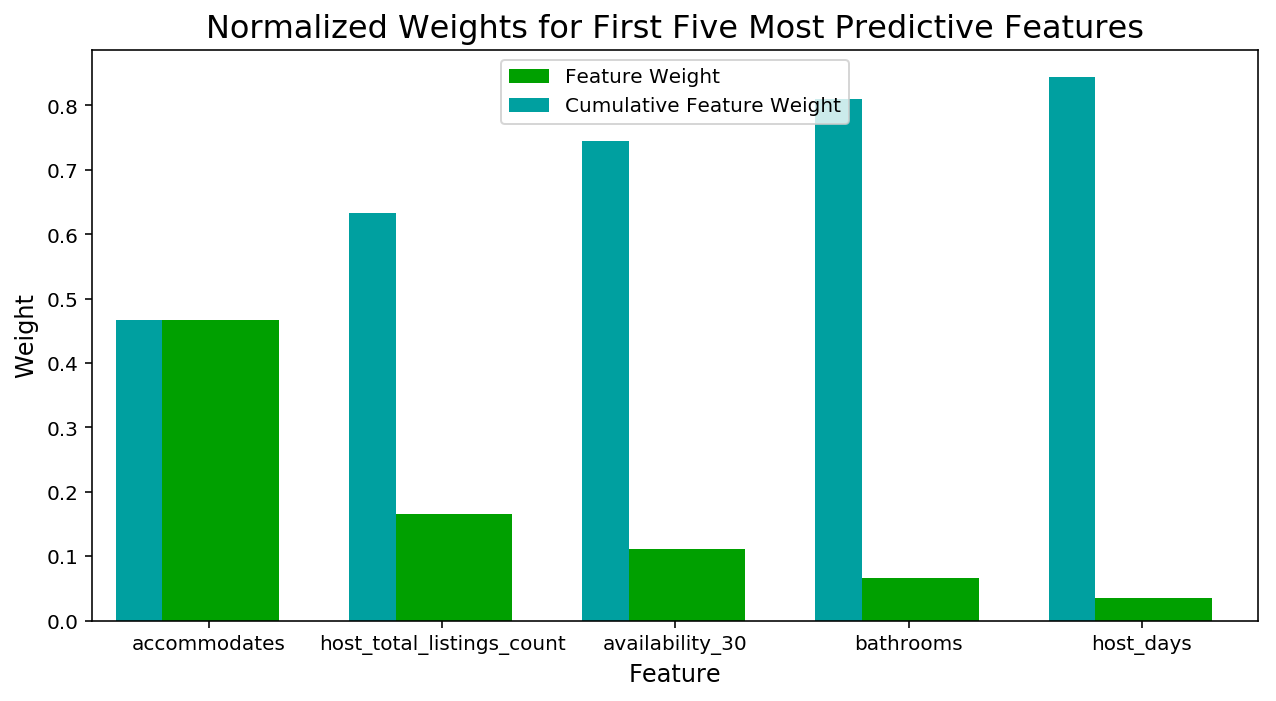

In [75]:
# Random forrests have an attribute for feature importances.  Plot these.

# Taken from Udacity Data Science Nanodegree
def feature_plot(importances, X_train, y_train):
    """
    Plots the feature importances from a model
    Supplied in a Udacity lectuer - thanks to Udacity.
    
    """
    # Display the five most important features
    indices = np.argsort(importances)[::-1]
    columns = X_train.columns.values[indices[:5]]
    values = importances[indices][:5]

    # Creat the plot
    fig = plt.figure(figsize = (9,5))
    plt.title("Normalized Weights for First Five Most Predictive Features", fontsize = 16)
    plt.bar(np.arange(5), values, width = 0.6, align="center", color = '#00A000', \
          label = "Feature Weight")
    plt.bar(np.arange(5) - 0.3, np.cumsum(values), width = 0.2, align = "center", color = '#00A0A0', \
          label = "Cumulative Feature Weight")
    plt.xticks(np.arange(5), columns)
    plt.xlim((-0.5, 4.5))
    plt.ylabel("Weight", fontsize = 12)
    plt.xlabel("Feature", fontsize = 12)
    
    plt.legend(loc = 'upper center')
    plt.tight_layout()
    plt.show()  

feature_plot(rf_model.best_estimator_.feature_importances_, X_train_v3_lt, y_train_v3_lt)

**Comment:** No surprises here - accommodates have by far the most importance.  We could guess the same from the correlation matrix.

In [76]:
# Try a simple linear regression with the features found most important in the random forrest regressor.
lr_model = linear_model.LinearRegression(normalize=True)
x = X_train_v3_lt[['accommodates', 'bathrooms', 'availability_30', 'host_total_listings_count', 'host_days']]
lr_model.fit(np.array(x), y_train_v3_lt)

lr_predictions = lr_model.predict(np.array(X_test_v3_lt[['accommodates', 'bathrooms', 
                                                         'availability_30', 'host_total_listings_count','host_days']]))

print('Log-transformed V3 linear regression: {}'.format(sqrt(mean_squared_error(np.expm1(y_test_v3_lt),
                                                                               np.expm1(lr_predictions)))))

Log-transformed V3 linear regression: 498.732478974797


**Comment:** Simple linear regression performs on par with more complicated algorithms like Adaboost for this problem and dataset.

# Analysis and Conclusion

### Question 1: Which areas of Oslo have the most Airbnb listings?
This is easily answered by the bar chart "Areas with most listings" above  - there are 5 areas that have by far more listings than the rest of the neighbourhoods:
* Grünerløkka
* Frogner
* Gamle Oslo
* St. Hanshaugen
* Sagene
It's also clear from the heatmap that the listings are quite concentrated in popular sub-areas in these neighbourhoods, such as Majorstua in Frogner borough.


### Question 2:  Which characteristics a property drives the Airbnb listing prices in Oslo?
From the "Correlation-matrix - all variables" visualization, one can see that "accomodates" have a relatively high correlation with price, which is logical, since this variable says something about how many people can stay in the property.  Generally, features that regards size are correlated, and correlates with price.  In addition, it seems like number of listings by hosts  is positively correlated with price (corr 0.2) - do "pros" tend to price their properties higher?

### Question 3: Is there a relationship between official housing prices and the prices people are asking for on Airbnb?
The correlation matrix shows no such relationship, but during the ML testing, removing the price_rank (ordinal representation of the neighbourhoods, ordered by official housing prices) degrades performance to a small degree.

### Question 4 and Conclusion: Is it possible to use machine learning techniques to predict the price of a listing?
I was not able to get very good results on this dataset, but it's reasonable given the nature of the data I ended up using.
The best model for prediction ended up being a random forrest regression model. I did many experiments trying out normalized/un-normalized version of the data, parameter searching, and adding/removing features, but the best RMSE score was 475, which is quite high given a test dataset with mean 948, even though the range was wide, from 201 to 8986 and standard deviation 585.  Future work should include better feature selection, feature engineering and more parameter searching as well as testing other algorithms.  In addition, I would expect better result if I had removed more of the very expensive properties and focused for instance on the majority within +- 3 standard deviations from the mean.
